In [2]:
from urllib.request import urlopen, Request
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from urllib.request import urlopen
from matplotlib import pyplot as plt
import math
import datetime
from time import sleep
import copy
import json
import sys
import csv
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
from statsmodels.stats.stattools import durbin_watson

In [318]:
def AutocorrelationTest(array):
    return durbin_watson(array)

def ReduceDates(dates):
    count = 0
    for date in dates:
        if count%5 != 0:
            dates[count] = ' '
        count += 1
    return dates        

def PlotColumn(df, columns, scaler = StandardScaler(), title=None, ylabel = None, xlabel = None):
    
    #color=np.random.rand(3,), label=column
    
    dff = df[columns].copy()
    dff['date'] = df['date']
    ax = plt.gca()
    ax.locator_params(nbins=40, axis='x')
    
    for column in columns:
        data = df[[column]]
        if scaler is not None:
            dff[column] = scaler.fit_transform(df[[column]])
       
        dff.plot(kind='line',x='date',y=column,ax=ax, figsize=(20,10),label=column)
        
        plt.xticks(rotation='80')
        plt.ylabel(ylabel, fontsize=25)
        plt.xlabel(xlabel, fontsize=25)
        plt.legend()
        plt.title(title, fontsize=40)
    
    del dff['date']
    return dff

def PlotCorrelationMatrix(dff, fontsize = 20):
    f = plt.figure(figsize=(20, 10))
    data = dff.corr();
    plt.matshow(data, fignum=f.number)
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=fontsize, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xticks(range(dff.shape[1]), dff.columns, fontsize=14, rotation=90)
    plt.yticks(range(dff.shape[1]), dff.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16);
    
def Predict(df, scaler = None, classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = None):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    return  classifier , X_train_r
    
def DefineThreeClasses(df):
    df['target_rise_fall'] = np.where((df.target > 100.00),'Rise',df.target_rise_fall)
    df['target_rise_fall'] = np.where((df.target <-100.00),'Fall',df.target_rise_fall)
    df['target_rise_fall'] = np.where(((df.target >=-100) & (df.target <=100)),'Stay',df.target_rise_fall)
    print('Rise'+ str(df[df.target_rise_fall == 'Rise'].shape[0]))
    print('Fall'+ str(df[df.target_rise_fall == 'Fall'].shape[0]))
    print('Stay'+ str(df[df.target_rise_fall == 'Stay'].shape[0]))
    return df
    

### Porovnanie otváracej a zatváracej ceny a target  ceny - zajtrajsia zatvaracia

In [23]:
df = pd.read_csv("data.csv")
dff = df[['date', 'open_price', 'close_price']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff = dff[:-1]
dff.head()

date  open_price  close_price  target_price
0  2019-03-26     3969.23      3985.08       4087.07
1  2019-03-27     3984.24      4087.07       4069.11
2  2019-03-28     4087.58      4069.11       4098.37
3  2019-03-29     4068.30      4098.37       4106.66
4  2019-03-30     4092.14      4106.66       4105.40

Durbin-Watson test for autocorrelation:  0.029893470012637983
Durbin-Watson test for autocorrelation:  0.030427994646320167
Durbin-Watson test for autocorrelation:  0.03108854336698612
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


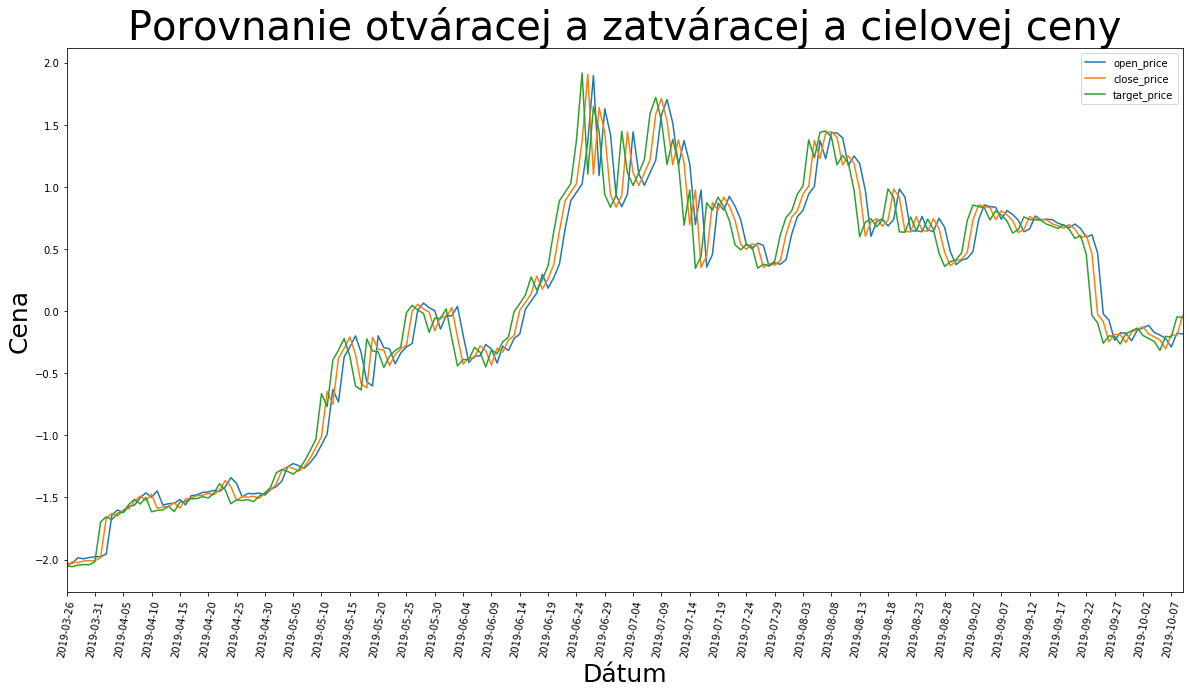

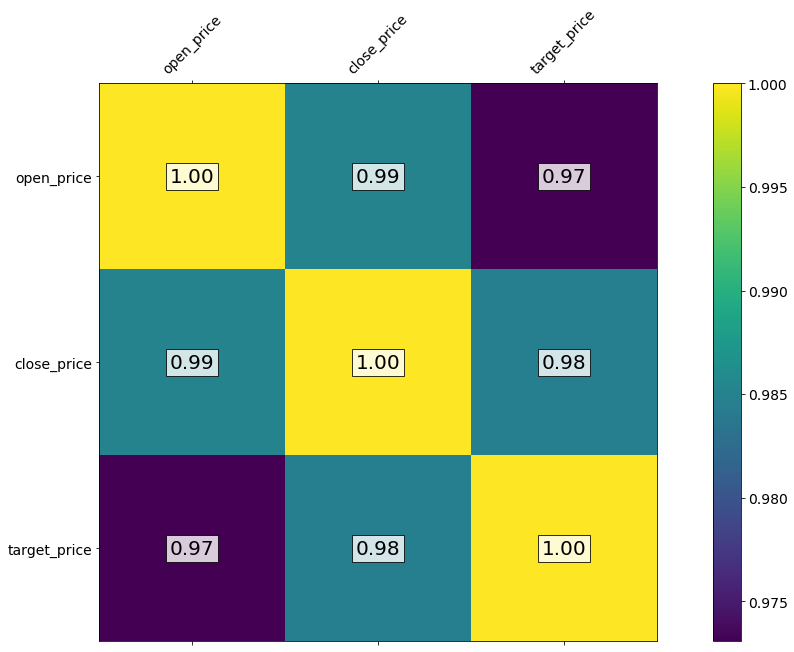

In [24]:
dfc = PlotColumn(dff, ['open_price', 'close_price', 'target_price'], scaler = StandardScaler(), title ='Porovnanie otváracej a zatváracej a cielovej ceny',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.open_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.close_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

### Zhodnotenie :

 - Dáta korelujú
 - Dáta sú viac menej len posunuté o 1 deň v čase
 - Dôkazom je Durbin-Watson test autokorelácie

# Porovnanie otváracej a zatváracej ceny - odstránená časová závislosť

In [29]:
df = pd.read_csv("data.csv")
dff = df[['date', 'open_price', 'close_price']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff = dff[:-1]
dff.head()

date  open_price  close_price  target_price
0  2019-03-26     3969.23      3985.08       4087.07
1  2019-03-27     3984.24      4087.07       4069.11
2  2019-03-28     4087.58      4069.11       4098.37
3  2019-03-29     4068.30      4098.37       4106.66
4  2019-03-30     4092.14      4106.66       4105.40

Durbin-Watson test for autocorrelation:  1.8410231245525337
Durbin-Watson test for autocorrelation:  1.8373377470681014
Durbin-Watson test for autocorrelation:  1.8458214899542889
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


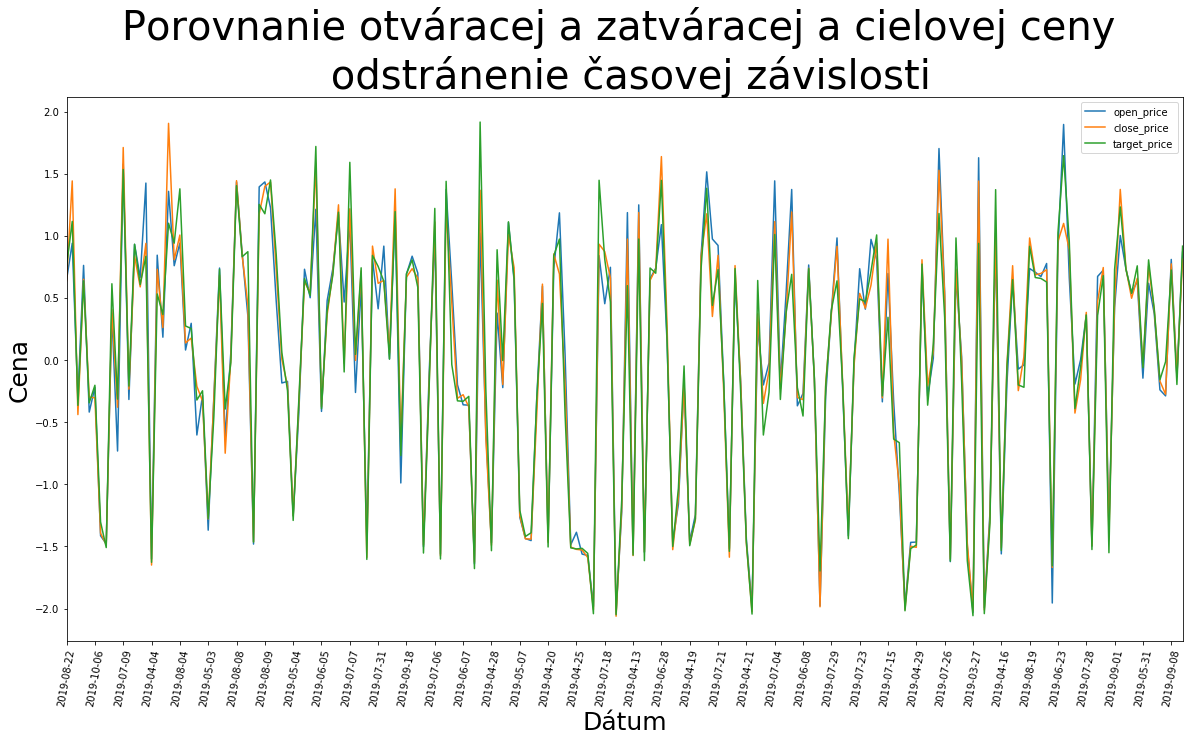

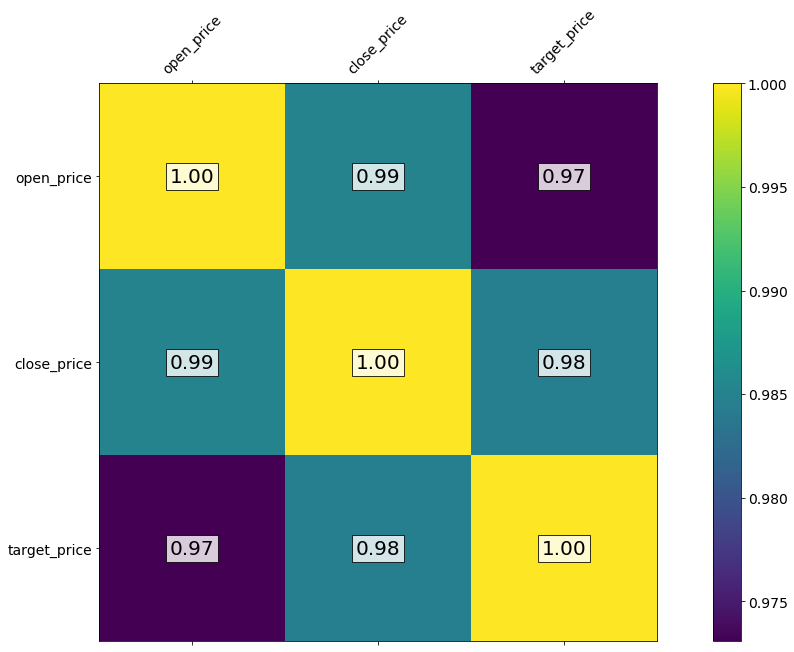

In [32]:
dff = shuffle(dff)
dfc = PlotColumn(dff, ['open_price', 'close_price', 'target_price'], scaler = StandardScaler(), title ='Porovnanie otváracej a zatváracej a cielovej ceny \n odstránenie časovej závislosti',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.open_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.close_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

### Zhodnotenie :

 - Dáta stále korelujú
 - Durbin-Watson vychádza ale pri časových radoch chceme často krát zachovať ich poradie

# Porovnanie diferencií otváracej a cielovej ceny 

In [50]:
df = pd.read_csv("data.csv")
dff = df[['date', 'open_price', 'close_price']].copy()
dff['d_open_price'] = np.append(np.diff(dff['open_price']), 0)
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff = dff[:-1]
dff.head()

date  open_price  close_price  d_open_price  target_price  \
0  2019-03-26     3969.23      3985.08         15.01       4087.07   
1  2019-03-27     3984.24      4087.07        103.34       4069.11   
2  2019-03-28     4087.58      4069.11        -19.28       4098.37   
3  2019-03-29     4068.30      4098.37         23.84       4106.66   
4  2019-03-30     4092.14      4106.66         13.32       4105.40   

   d_target_price  
0          101.99  
1          -17.96  
2           29.26  
3            8.29  
4           -1.26

Durbin-Watson test for autocorrelation:  2.216252452896838
Durbin-Watson test for autocorrelation:  2.2052005478431154
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


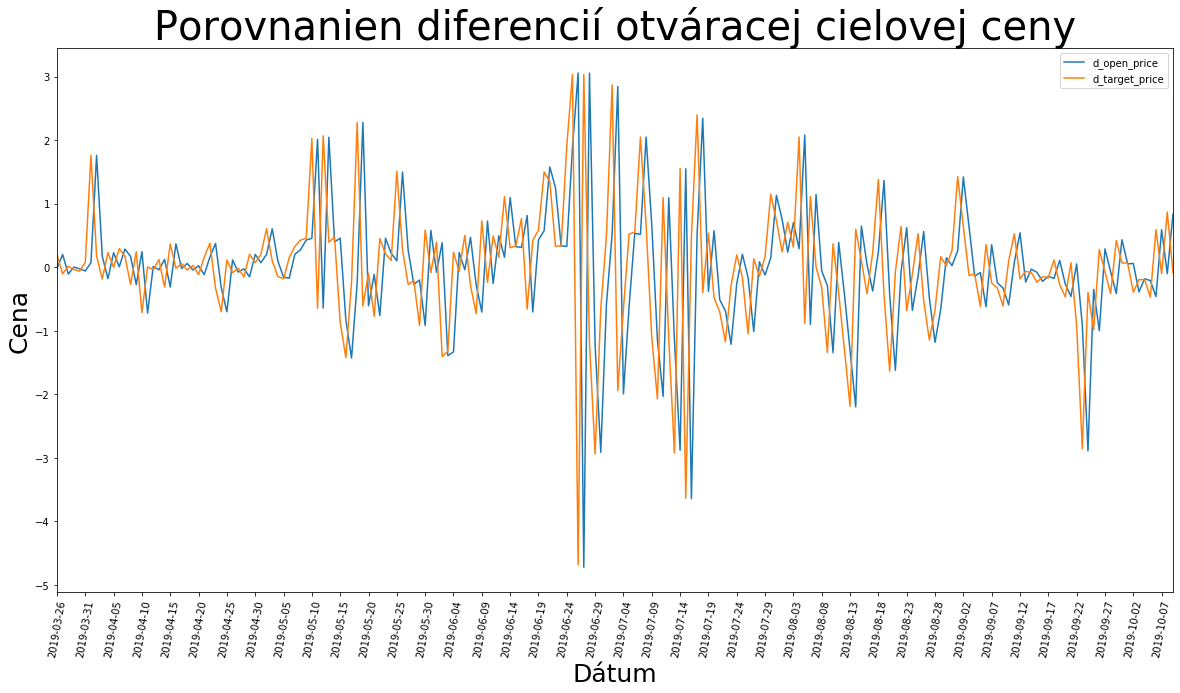

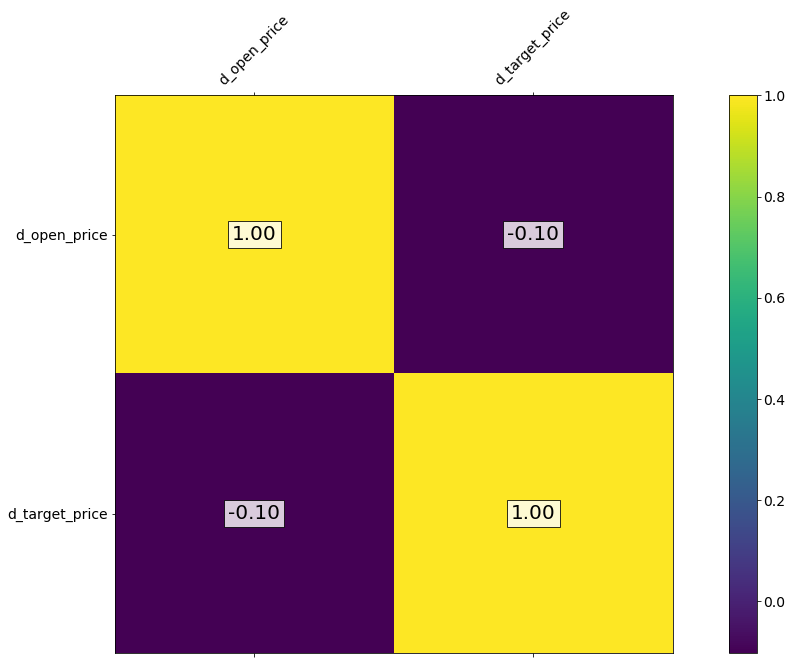

In [44]:
dfc = PlotColumn(dff, ['d_open_price', 'd_target_price'], scaler = StandardScaler(), title ='Porovnanien diferencií otváracej cielovej ceny',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_open_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

In [ ]:
df = df.iloc[1:]
df.head()

### Zhodnotenie :

 - Dáta vizuálne korelujú
 - Durbin-Watson poukazuje na vyriešenie problému autokorelácie aj bez pouzitia shuffle
 - v čom spočíva vizuálna korelácia?

# Porovnanie diferencií otváracej a zatváracej ceny  - odstránená časová závislosť

In [40]:
df = pd.read_csv("data.csv")
dff = df[['date', 'open_price', 'close_price']].copy()
dff['d_open_price'] = np.append(np.diff(dff['open_price']), 0)
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff = dff[:-1]
dff.head()

date  open_price  close_price  d_open_price  target_price  \
0  2019-03-26     3969.23      3985.08         15.01       4087.07   
1  2019-03-27     3984.24      4087.07        103.34       4069.11   
2  2019-03-28     4087.58      4069.11        -19.28       4098.37   
3  2019-03-29     4068.30      4098.37         23.84       4106.66   
4  2019-03-30     4092.14      4106.66         13.32       4105.40   

   d_target_price  
0          101.99  
1          -17.96  
2           29.26  
3            8.29  
4           -1.26

Durbin-Watson test for autocorrelation:  1.8562753144984532
Durbin-Watson test for autocorrelation:  1.8524043435300102
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


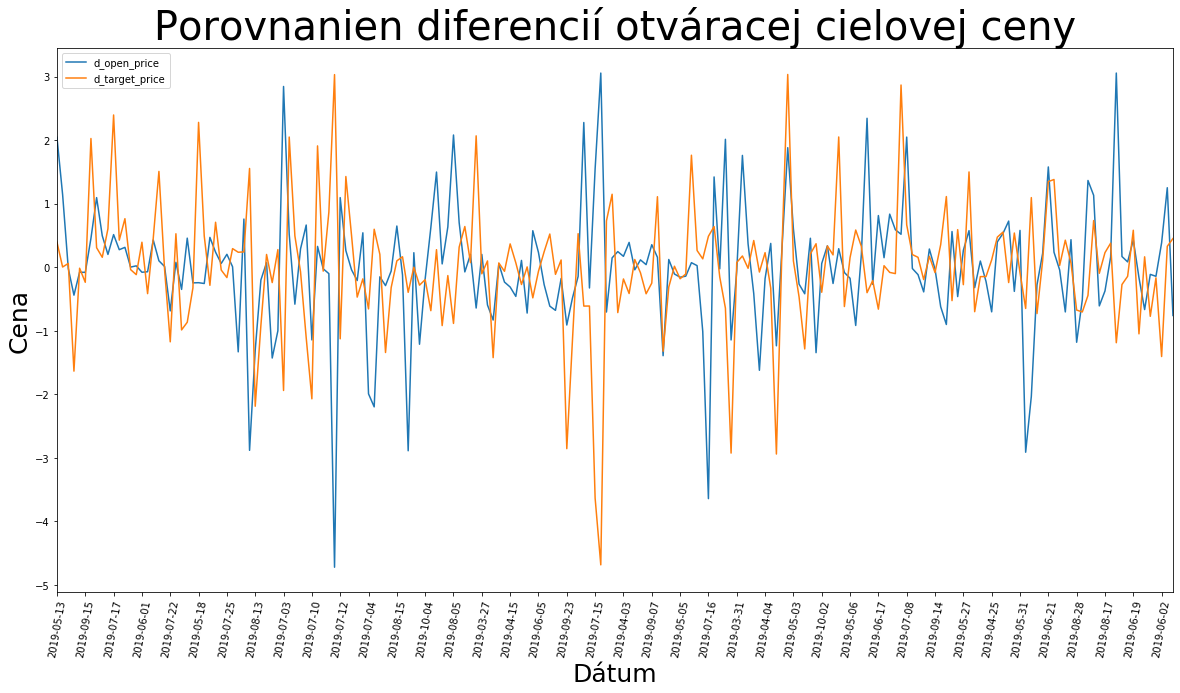

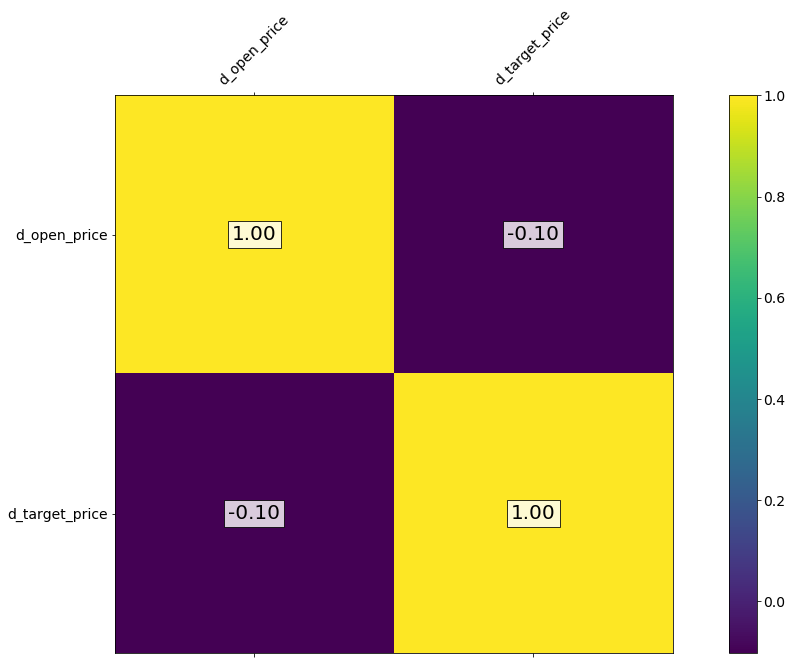

In [45]:
dff = shuffle(dff)
dfc = PlotColumn(dff, ['d_open_price', 'd_target_price'], scaler = StandardScaler(), title ='Porovnanien diferencií otváracej cielovej ceny',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_open_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

### Zhodnotenie :

 - Dáta vizuálne korelovali lebo boli časovo závislé
 - derivácie sú spôsob ktorým vyriešiť autokoreláciu aj bez porušenia časovej závislosti

# Market Volume a zatváracia cena


In [48]:
df = pd.read_csv("data.csv")
dff = df[['date', 'open_price', 'close_price', 'market_volume']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff = dff[:-1]
dff.head()

date  open_price  close_price  market_volume  target_price
0  2019-03-26     3969.23      3985.08   1.070768e+10       4087.07
1  2019-03-27     3984.24      4087.07   1.089713e+10       4069.11
2  2019-03-28     4087.58      4069.11   9.353916e+09       4098.37
3  2019-03-29     4068.30      4098.37   1.091867e+10       4106.66
4  2019-03-30     4092.14      4106.66   9.732688e+09       4105.40

Durbin-Watson test for autocorrelation:  0.03108854336698612
Durbin-Watson test for autocorrelation:  0.33836648338742364
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


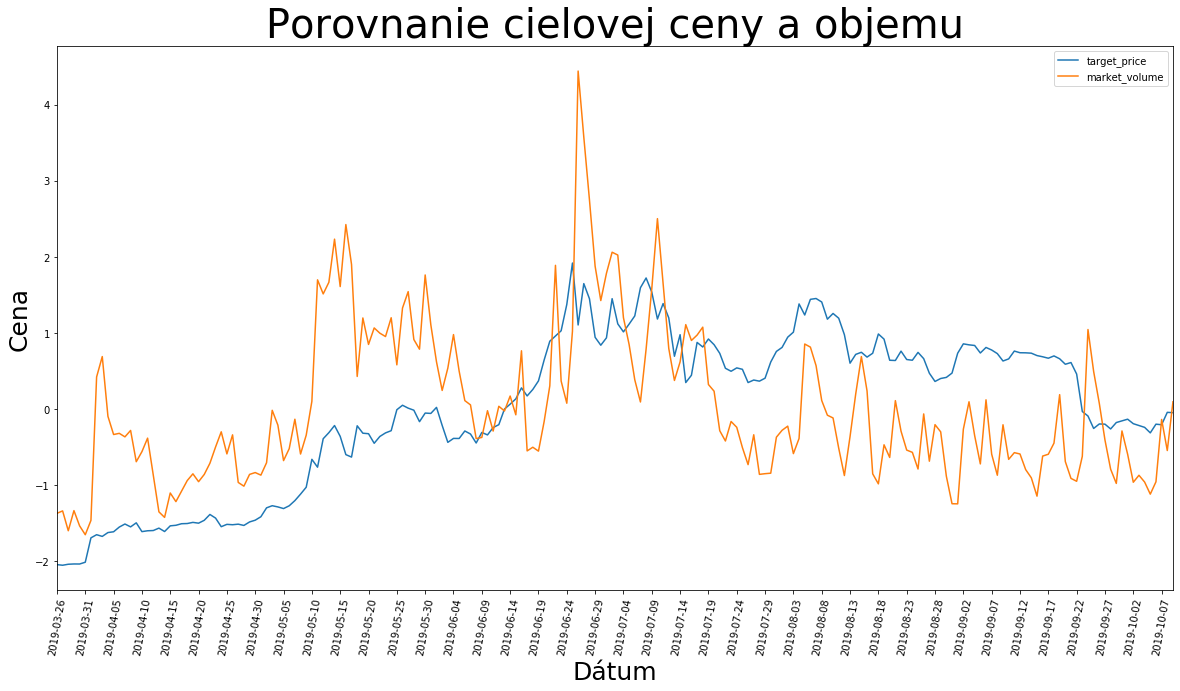

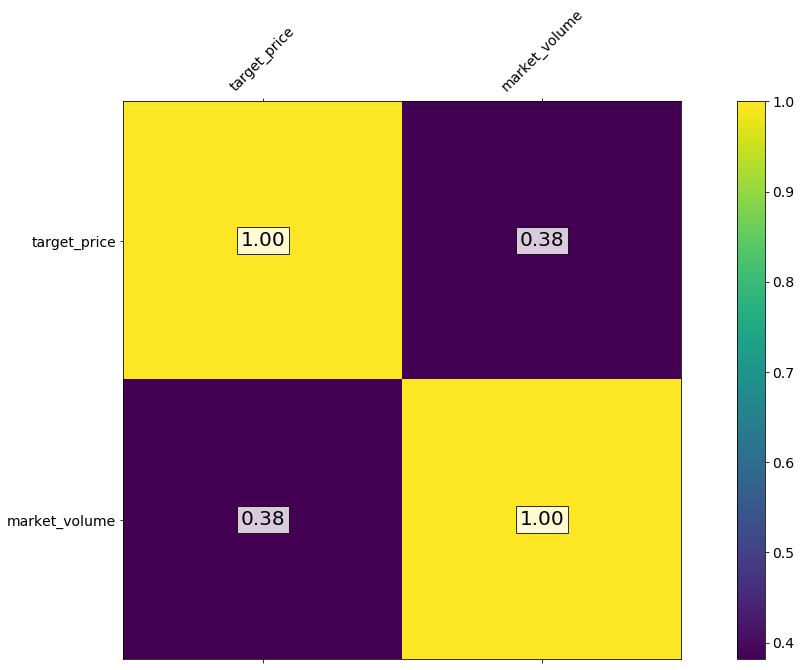

In [49]:
dfc = PlotColumn(dff, ['target_price','market_volume'], scaler = StandardScaler(), title ='Porovnanie cielovej ceny a objemu',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.market_volume)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

## Zhodnotenie:

 - Dáta sú relatívne korelované ale zároveň sú autokorelované => treba porovnat korelaciu ich diferencii

# Market Volume a zatváracia cena - diferencie

In [53]:
df = pd.read_csv("data.csv")
dff = df[['date', 'open_price', 'close_price', 'market_volume']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_market_volume'] = np.insert(np.diff(dff['market_volume']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  open_price  close_price  market_volume  target_price  \
1  2019-03-27     3984.24      4087.07   1.089713e+10       4069.11   
2  2019-03-28     4087.58      4069.11   9.353916e+09       4098.37   
3  2019-03-29     4068.30      4098.37   1.091867e+10       4106.66   
4  2019-03-30     4092.14      4106.66   9.732688e+09       4105.40   
5  2019-03-31     4105.46      4105.40   9.045122e+09       4158.18   

   d_target_price  d_market_volume  
1          -17.96     1.894531e+08  
2           29.26    -1.543216e+09  
3            8.29     1.564750e+09  
4           -1.26    -1.185977e+09  
5           52.78    -6.875656e+08

Durbin-Watson test for autocorrelation:  2.205179885558197
Durbin-Watson test for autocorrelation:  2.0687948141300656
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


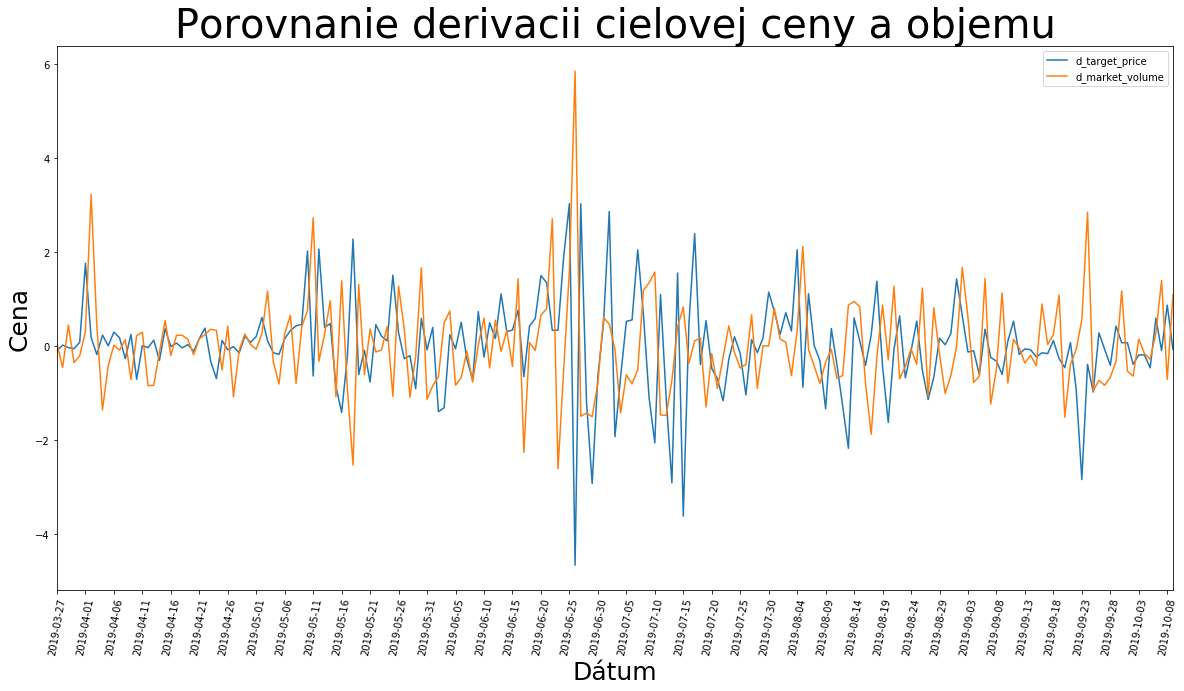

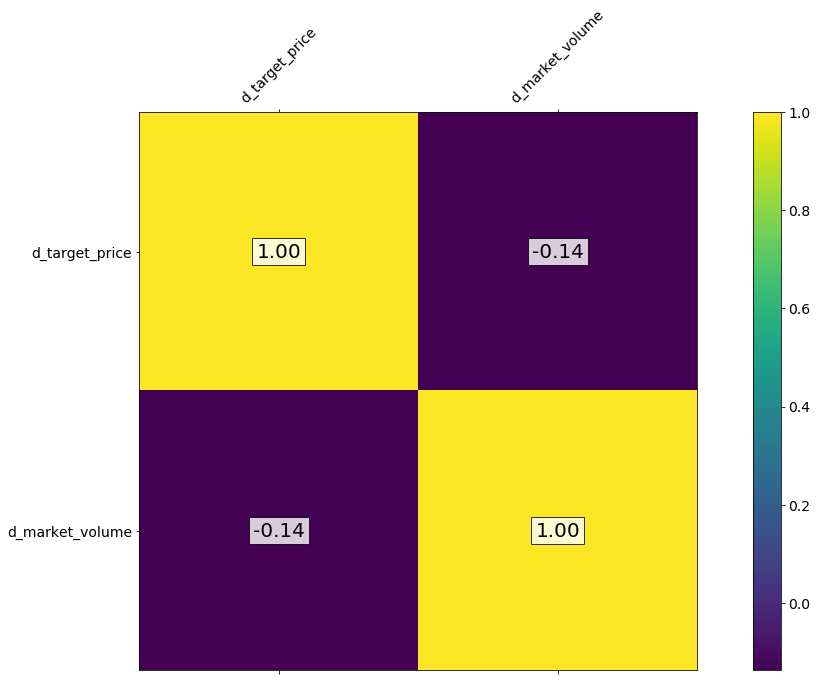

In [54]:
dfc = PlotColumn(dff, ['d_target_price','d_market_volume'], scaler = StandardScaler(), title ='Porovnanie derivacii cielovej ceny a objemu',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_market_volume)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# Market cap a cielova cena

In [59]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'market_cap']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_market_cap'] = np.insert(np.diff(dff['market_cap']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price    market_cap  target_price  d_target_price  \
1  2019-03-27      4087.07  7.198785e+10       4069.11          -17.96   
2  2019-03-28      4069.11  7.167900e+10       4098.37           29.26   
3  2019-03-29      4098.37  7.220209e+10       4106.66            8.29   
4  2019-03-30      4106.66  7.235519e+10       4105.40           -1.26   
5  2019-03-31      4105.40  7.233938e+10       4158.18           52.78   

   d_market_cap  
1  1.803700e+09  
2 -3.088487e+08  
3  5.230900e+08  
4  1.531018e+08  
5 -1.581161e+07

Durbin-Watson test for autocorrelation:  2.0404189940801305
Durbin-Watson test for autocorrelation:  2.0608337108059707
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


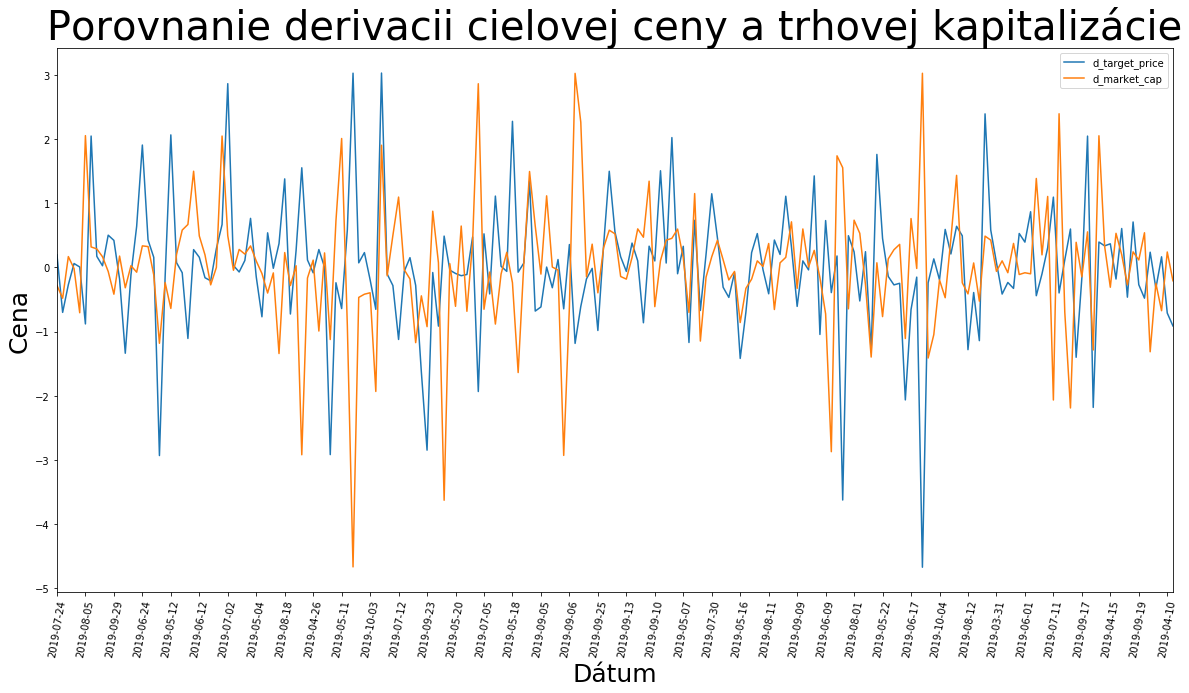

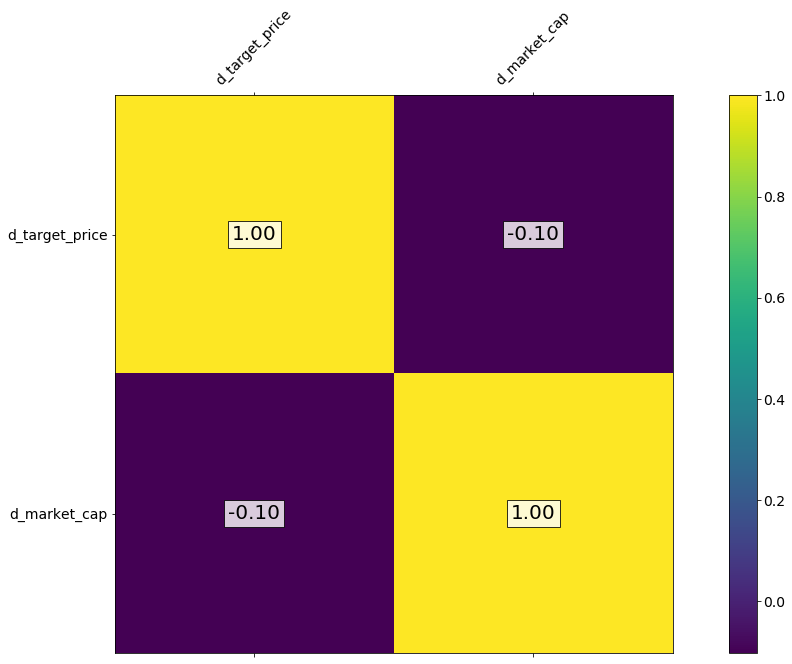

In [61]:
dff = shuffle(dff)
dfc = PlotColumn(dff, ['d_target_price','d_market_cap'], scaler = StandardScaler(), title ='Porovnanie derivacii cielovej ceny a trhovej kapitalizácie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_market_cap)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

## Zhodnotenie:

 - Market Cap  -Tržní kapitalizace  anglicky market capitalization, nebo zkráceně market cap – je termín, který určuje hodnotu aktiva, v našem případě kryptoměny, na trhu. Jde taky o měřítko velikosti dané kryptoměny; čím větší tržní kapitalizaci kryptoměna má, tím větší je v porovnání s ostatními. Bitcoin je momentálně největší kryptoměnou, tím pádem má největší market cap.
 - Výpočet - Trhová cena (price) x Cirkulujúca dodávka (circulating supply - objem BTC v obehu)
 - Premenná obsahuje zložku ceny a je prenásobené čoraz pomalšie rastúcim koeficientom objemu 
 - Elimináciu autokorelácie nemá zmysel riešiť lebo hodnoty sú identické - vychádzajú z rovného základu

# Cielová cena a Počet transakcií

In [62]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'num_of_transaction']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_num_of_transaction'] = np.insert(np.diff(dff['num_of_transaction']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  num_of_transaction  target_price  d_target_price  \
1  2019-03-27      4087.07              383186       4069.11          -17.96   
2  2019-03-28      4069.11              393698       4098.37           29.26   
3  2019-03-29      4098.37              369817       4106.66            8.29   
4  2019-03-30      4106.66              377783       4105.40           -1.26   
5  2019-03-31      4105.40              381652       4158.18           52.78   

   d_num_of_transaction  
1                 16771  
2                 10512  
3                -23881  
4                  7966  
5                  3869

Durbin-Watson test for autocorrelation:  0.03176564675590628
Durbin-Watson test for autocorrelation:  0.950931110913788
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


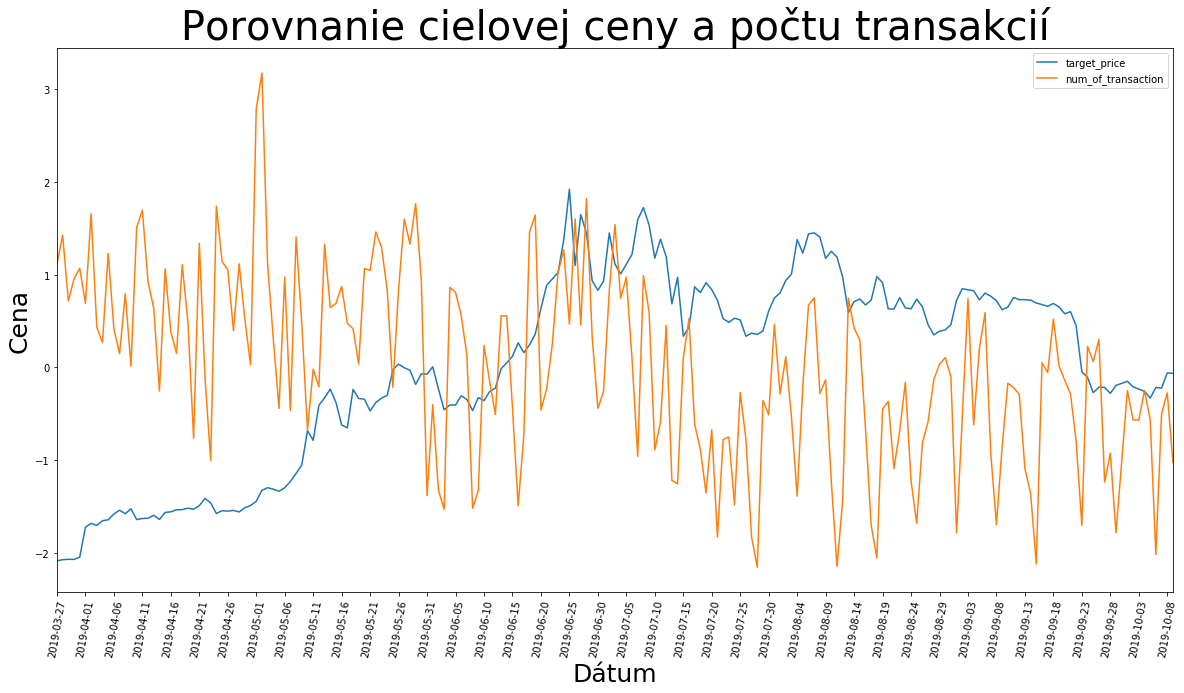

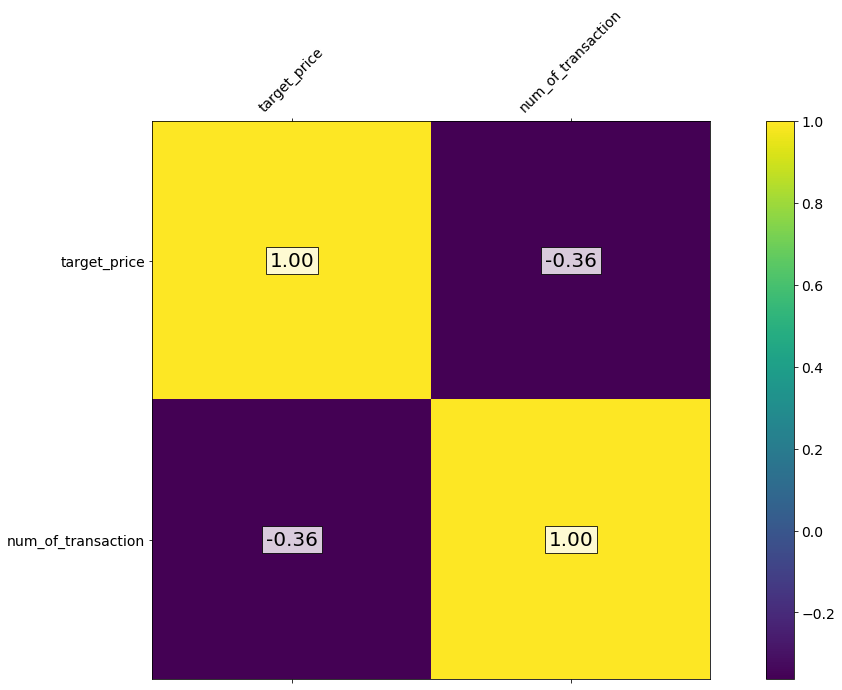

In [64]:
dfc = PlotColumn(dff, ['target_price','num_of_transaction'], scaler = StandardScaler(), title ='Porovnanie cielovej ceny a počtu transakcií',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.num_of_transaction)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

## Zhodnotenie:
 - hodnoty sú mierne korelované

# Diferencia Cielovej cena a Počet transakcií

In [72]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'num_of_transaction']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_num_of_transaction'] = np.insert(np.diff(dff['num_of_transaction']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  num_of_transaction  target_price  d_target_price  \
1  2019-03-27      4087.07              383186       4069.11          -17.96   
2  2019-03-28      4069.11              393698       4098.37           29.26   
3  2019-03-29      4098.37              369817       4106.66            8.29   
4  2019-03-30      4106.66              377783       4105.40           -1.26   
5  2019-03-31      4105.40              381652       4158.18           52.78   

   d_num_of_transaction  
1                 16771  
2                 10512  
3                -23881  
4                  7966  
5                  3869

Durbin-Watson test for autocorrelation:  2.205179885558197
Durbin-Watson test for autocorrelation:  2.4402467926045306
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


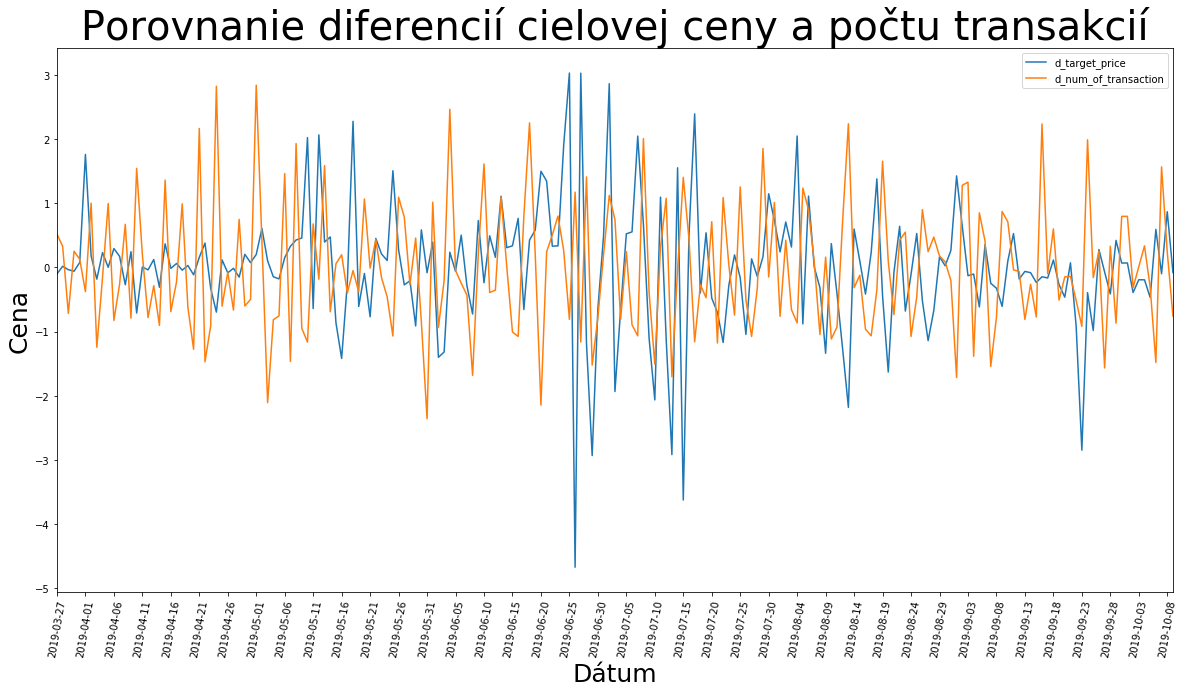

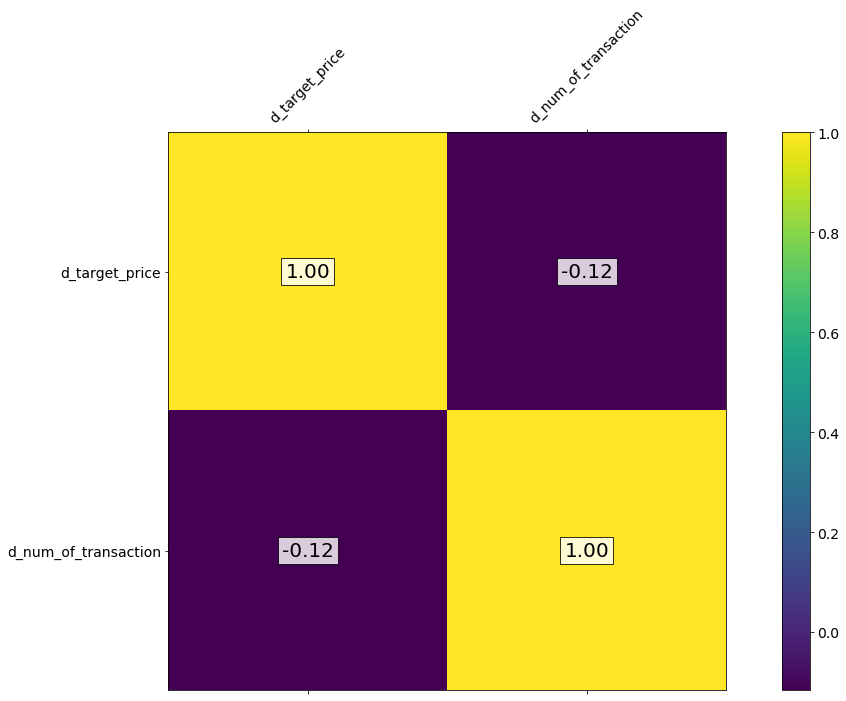

In [74]:
dfc = PlotColumn(dff, ['d_target_price','d_num_of_transaction'], scaler = StandardScaler(), title ='Porovnanie diferencií cielovej ceny a počtu transakcií',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_num_of_transaction)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# Cena a suma získaná banníkmi

In [82]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'miners_revenue']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_miners_revenue'] = np.insert(np.diff(dff['miners_revenue']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  miners_revenue  target_price  d_target_price  \
1  2019-03-27      4087.07         7663796       4069.11          -17.96   
2  2019-03-28      4069.11         7555049       4098.37           29.26   
3  2019-03-29      4098.37         7747502       4106.66            8.29   
4  2019-03-30      4106.66         7361068       4105.40           -1.26   
5  2019-03-31      4105.40         7323231       4158.18           52.78   

   d_miners_revenue  
1            931169  
2           -108747  
3            192453  
4           -386434  
5            -37837

Durbin-Watson test for autocorrelation:  0.03176564675590628
Durbin-Watson test for autocorrelation:  0.209975494063242
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


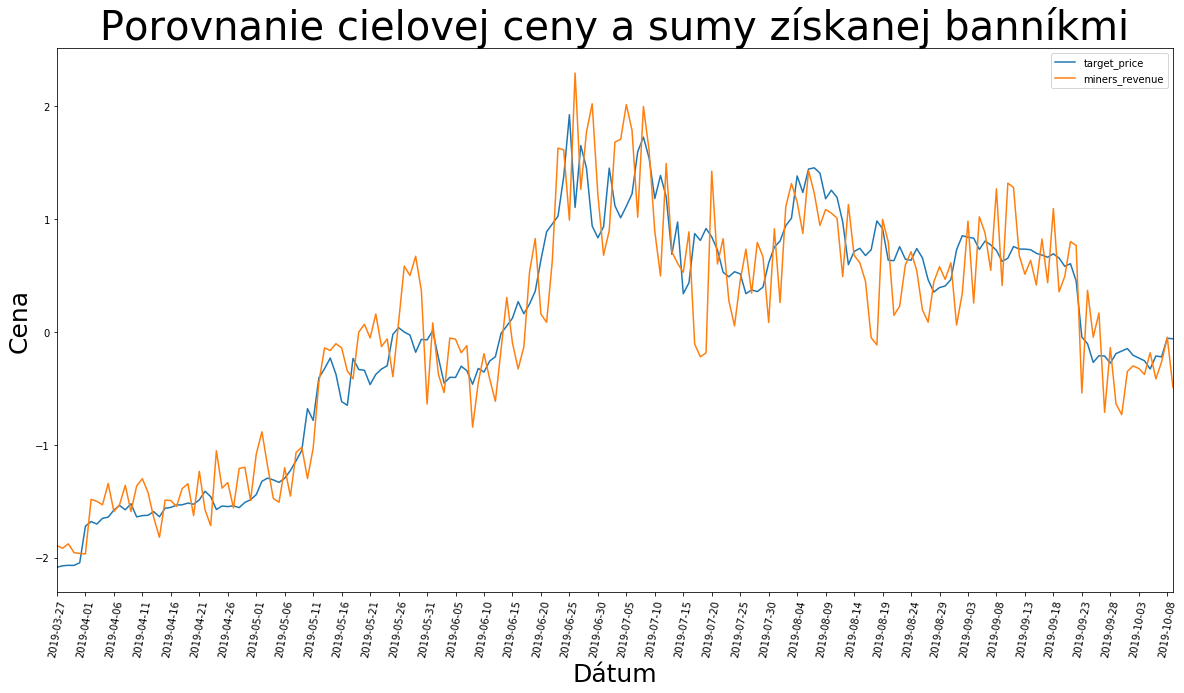

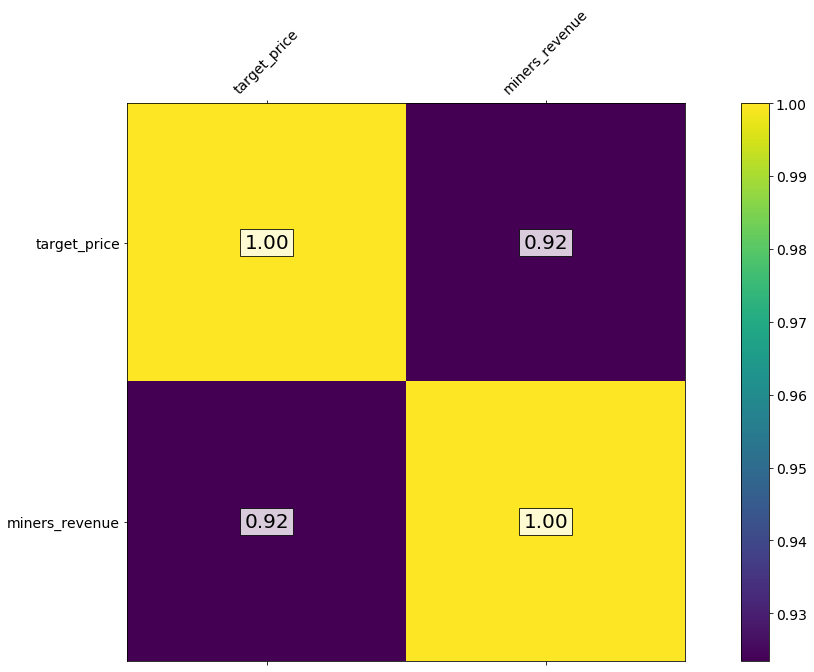

In [83]:
dfc = PlotColumn(dff, ['target_price','miners_revenue'], scaler = StandardScaler(), title ='Porovnanie cielovej ceny a sumy získanej banníkmi',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.miners_revenue)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# Cena a suma získaná banníkmi

In [84]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'miners_revenue']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_miners_revenue'] = np.insert(np.diff(dff['miners_revenue']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  miners_revenue  target_price  d_target_price  \
1  2019-03-27      4087.07         7663796       4069.11          -17.96   
2  2019-03-28      4069.11         7555049       4098.37           29.26   
3  2019-03-29      4098.37         7747502       4106.66            8.29   
4  2019-03-30      4106.66         7361068       4105.40           -1.26   
5  2019-03-31      4105.40         7323231       4158.18           52.78   

   d_miners_revenue  
1            931169  
2           -108747  
3            192453  
4           -386434  
5            -37837

Durbin-Watson test for autocorrelation:  2.205179885558197
Durbin-Watson test for autocorrelation:  2.7498451834640973
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


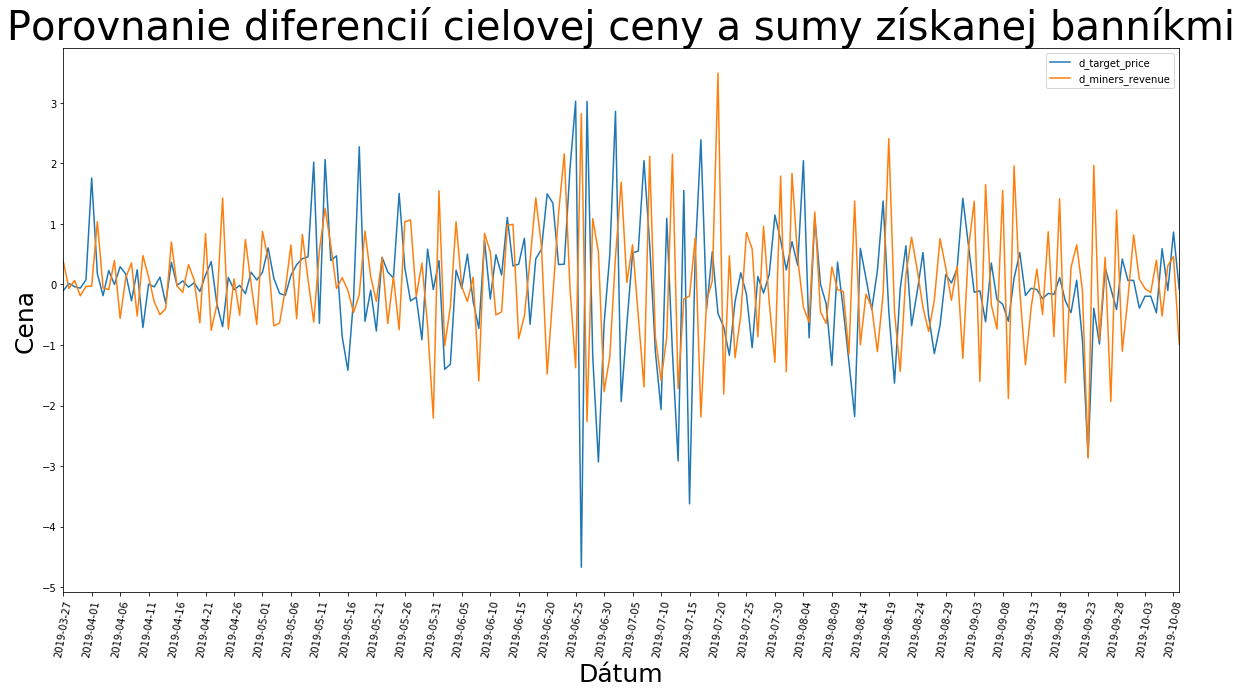

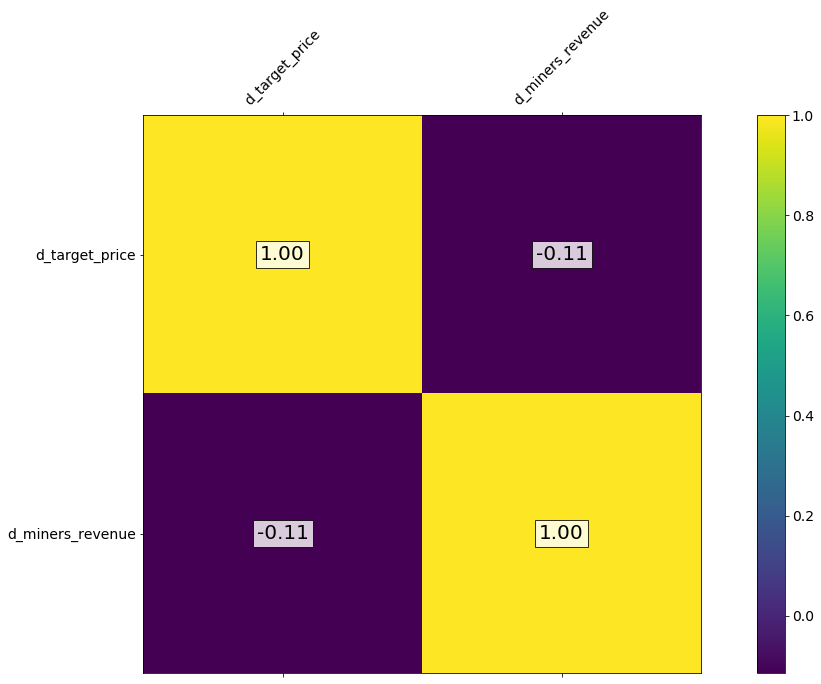

In [85]:
dfc = PlotColumn(dff, ['d_target_price','d_miners_revenue'], scaler = StandardScaler(), title ='Porovnanie diferencií cielovej ceny a sumy získanej banníkmi',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_miners_revenue)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# Cena a poplatky za transakcie

In [91]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'total_trans_fees']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_total_trans_fees'] = np.insert(np.diff(dff['total_trans_fees']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  total_trans_fees  target_price  d_target_price  \
1  2019-03-27      4087.07                48       4069.11          -17.96   
2  2019-03-28      4069.11                47       4098.37           29.26   
3  2019-03-29      4098.37                63       4106.66            8.29   
4  2019-03-30      4106.66                54       4105.40           -1.26   
5  2019-03-31      4105.40                44       4158.18           52.78   

   d_total_trans_fees  
1                  12  
2                  -1  
3                  16  
4                  -9  
5                 -10

Durbin-Watson test for autocorrelation:  0.03176564675590628
Durbin-Watson test for autocorrelation:  0.20504939846318618
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


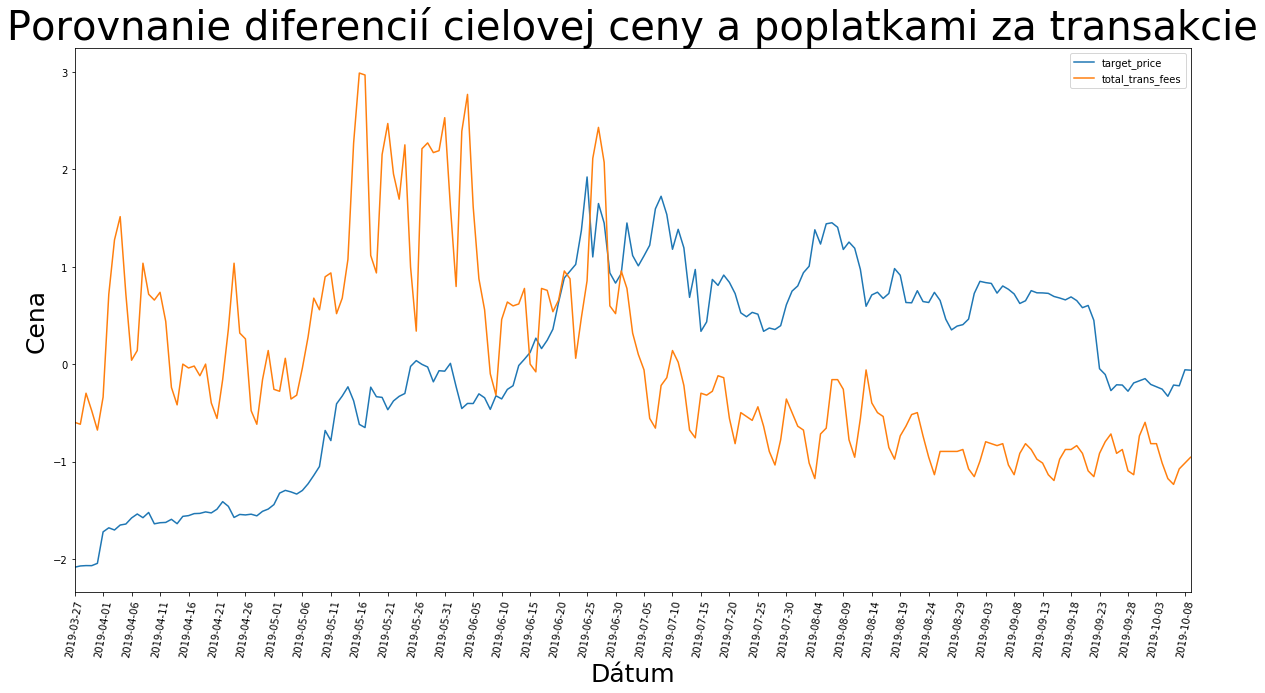

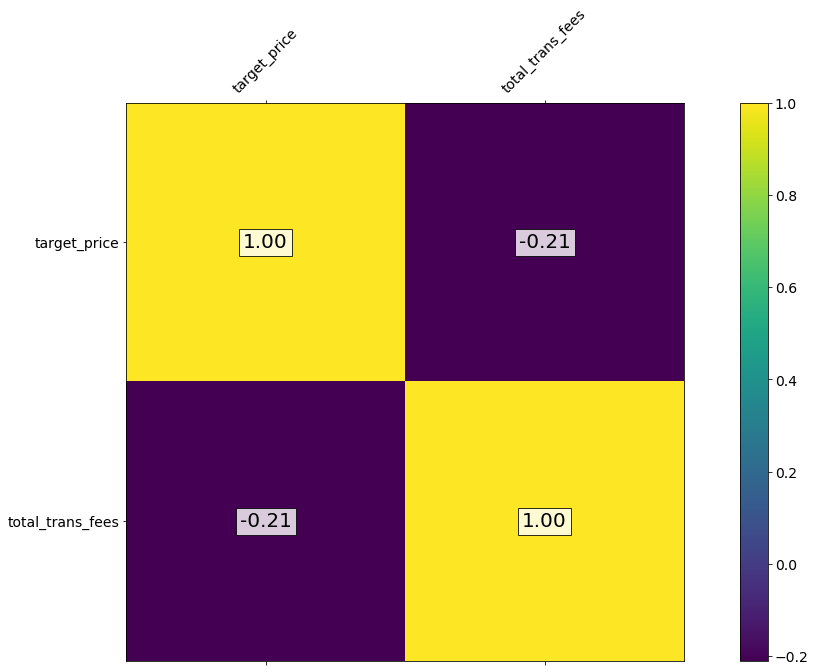

In [92]:
dfc = PlotColumn(dff, ['target_price','total_trans_fees'], scaler = StandardScaler(), title ='Porovnanie diferencií cielovej ceny a poplatkami za transakcie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.total_trans_fees)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

In [93]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'total_trans_fees']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_total_trans_fees'] = np.insert(np.diff(dff['total_trans_fees']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  total_trans_fees  target_price  d_target_price  \
1  2019-03-27      4087.07                48       4069.11          -17.96   
2  2019-03-28      4069.11                47       4098.37           29.26   
3  2019-03-29      4098.37                63       4106.66            8.29   
4  2019-03-30      4106.66                54       4105.40           -1.26   
5  2019-03-31      4105.40                44       4158.18           52.78   

   d_total_trans_fees  
1                  12  
2                  -1  
3                  16  
4                  -9  
5                 -10

Durbin-Watson test for autocorrelation:  2.205179885558197
Durbin-Watson test for autocorrelation:  1.7590720356162155
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


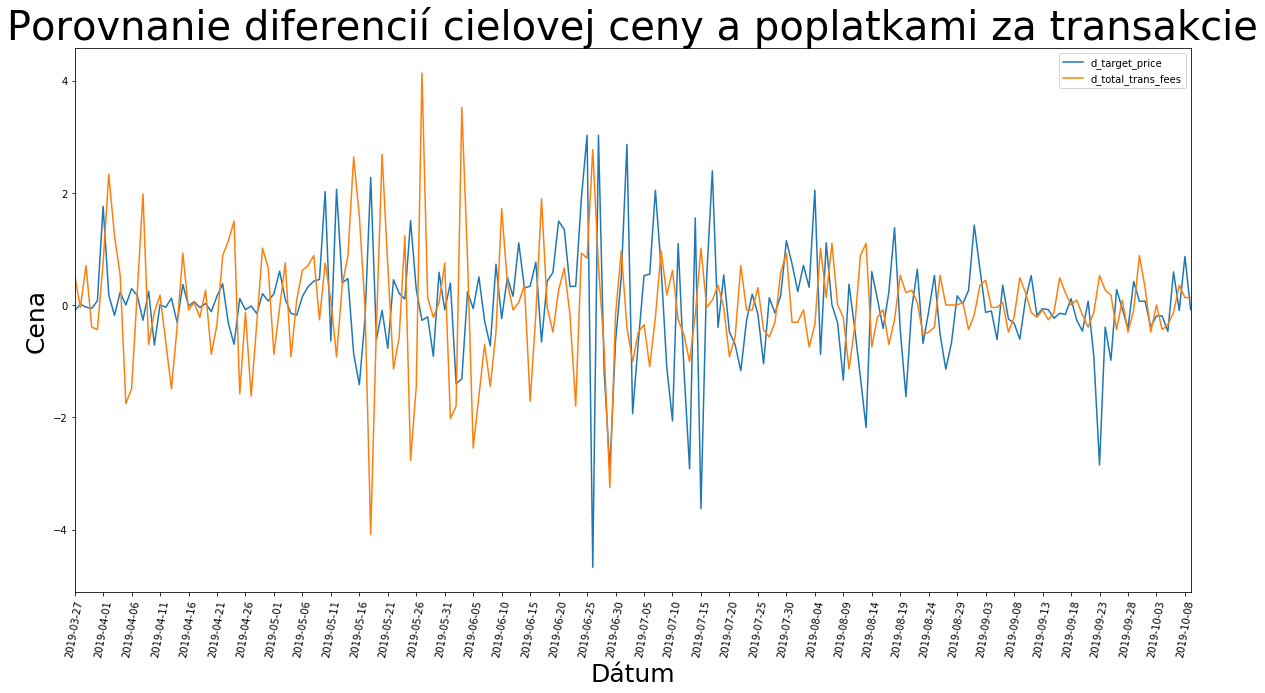

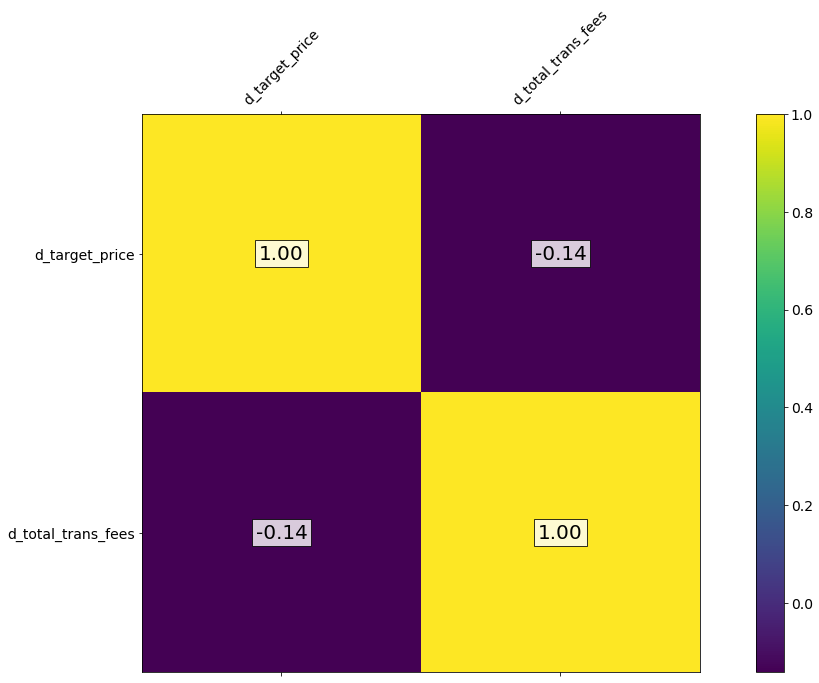

In [95]:
dfc = PlotColumn(dff, ['d_target_price','d_total_trans_fees'], scaler = StandardScaler(), title ='Porovnanie diferencií cielovej ceny a poplatkami za transakcie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_total_trans_fees)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# Output volume

In [97]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'output_volume']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_output_volume'] = np.insert(np.diff(dff['output_volume']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  output_volume  target_price  d_target_price  \
1  2019-03-27      4087.07        1229363       4069.11          -17.96   
2  2019-03-28      4069.11        1227019       4098.37           29.26   
3  2019-03-29      4098.37        1223853       4106.66            8.29   
4  2019-03-30      4106.66        1162220       4105.40           -1.26   
5  2019-03-31      4105.40        1185152       4158.18           52.78   

   d_output_volume  
1           -32963  
2            -2344  
3            -3166  
4           -61633  
5            22932

Durbin-Watson test for autocorrelation:  0.03176564675590628
Durbin-Watson test for autocorrelation:  0.14549405706183782
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


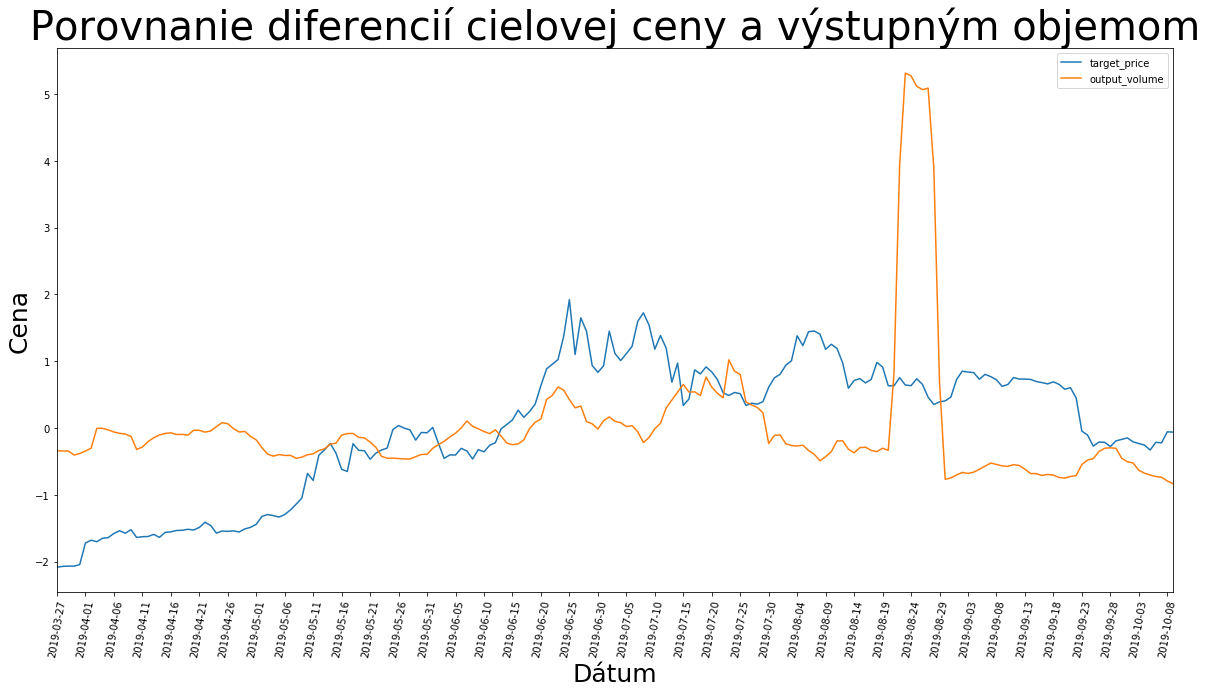

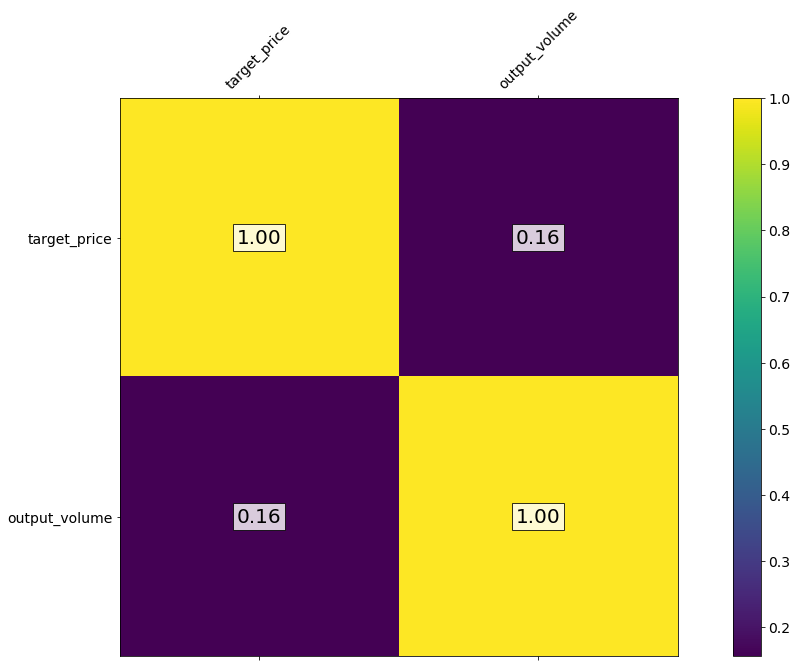

In [99]:
dfc = PlotColumn(dff, ['target_price','output_volume'], scaler = StandardScaler(), title ='Porovnanie diferencií cielovej ceny a výstupným objemom',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.output_volume)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

In [102]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price', 'output_volume']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_output_volume'] = np.insert(np.diff(dff['output_volume']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  output_volume  target_price  d_target_price  \
1  2019-03-27      4087.07        1229363       4069.11          -17.96   
2  2019-03-28      4069.11        1227019       4098.37           29.26   
3  2019-03-29      4098.37        1223853       4106.66            8.29   
4  2019-03-30      4106.66        1162220       4105.40           -1.26   
5  2019-03-31      4105.40        1185152       4158.18           52.78   

   d_output_volume  
1           -32963  
2            -2344  
3            -3166  
4           -61633  
5            22932

Durbin-Watson test for autocorrelation:  2.205179885558197
Durbin-Watson test for autocorrelation:  0.8502579712255358
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


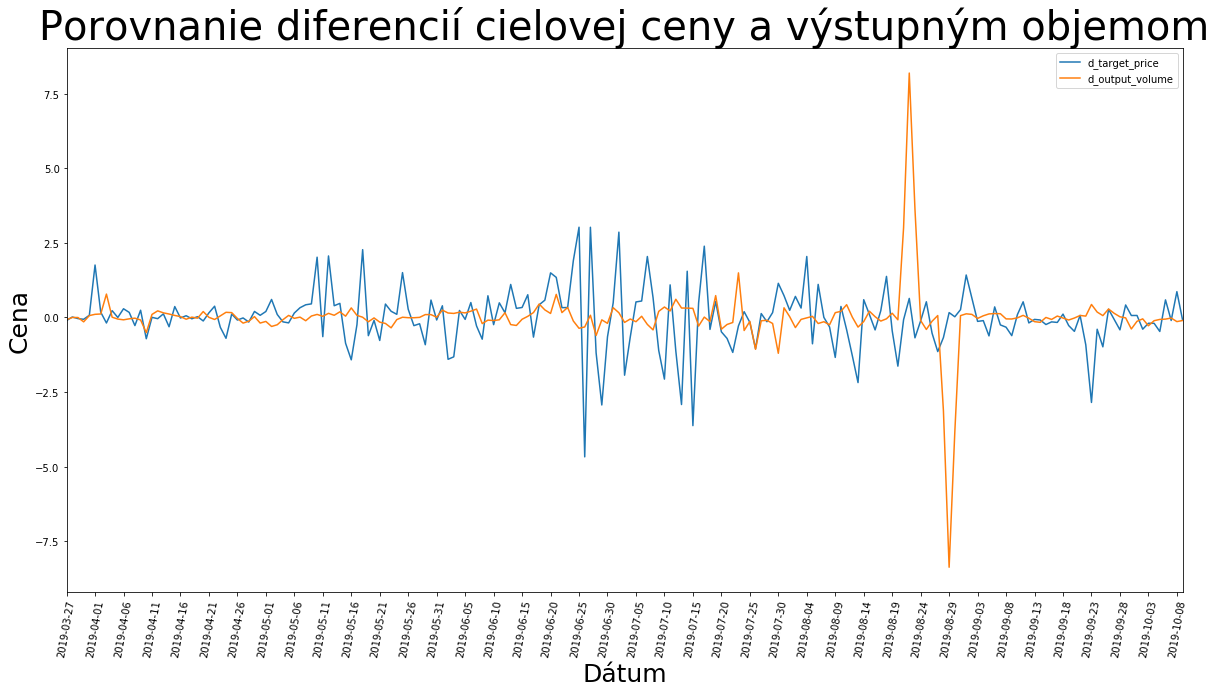

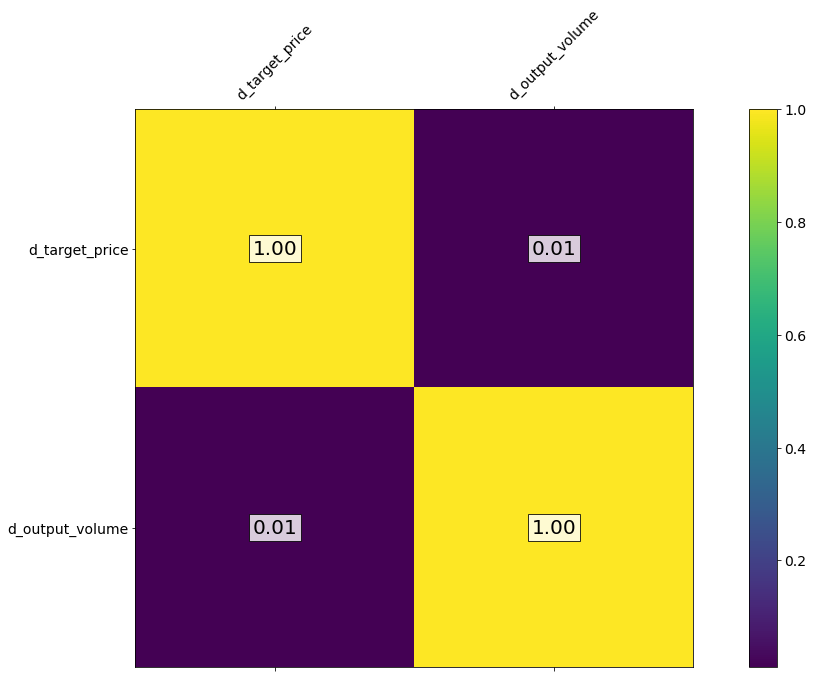

In [103]:
dfc = PlotColumn(dff, ['d_target_price','d_output_volume'], scaler = StandardScaler(), title ='Porovnanie diferencií cielovej ceny a výstupným objemom',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for autocorrelation:  " + str(AutocorrelationTest(dfc.d_output_volume)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# SUMAR BITCOIN HISTORICAL DATA - základný prehľad


In [109]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price','market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees','output_volume']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_market_volume'] = np.insert(np.diff(dff['market_volume']), 0, 0)
dff['d_market_cap'] = np.insert(np.diff(dff['market_cap']), 0, 0)
dff['d_num_of_transaction'] = np.insert(np.diff(dff['num_of_transaction']), 0, 0)
dff['d_miners_revenue'] = np.insert(np.diff(dff['miners_revenue']), 0, 0)
dff['d_total_trans_fees'] = np.insert(np.diff(dff['total_trans_fees']), 0, 0)
dff['d_output_volume'] = np.insert(np.diff(dff['output_volume']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  market_volume    market_cap  num_of_transaction  \
1  2019-03-27      4087.07   1.089713e+10  7.198785e+10              383186   
2  2019-03-28      4069.11   9.353916e+09  7.167900e+10              393698   
3  2019-03-29      4098.37   1.091867e+10  7.220209e+10              369817   
4  2019-03-30      4106.66   9.732688e+09  7.235519e+10              377783   
5  2019-03-31      4105.40   9.045122e+09  7.233938e+10              381652   

   miners_revenue  total_trans_fees  output_volume  target_price  \
1         7663796                48        1229363       4069.11   
2         7555049                47        1227019       4098.37   
3         7747502                63        1223853       4106.66   
4         7361068                54        1162220       4105.40   
5         7323231                44        1185152       4158.18   

   d_target_price  d_market_volume  d_market_cap  d_num_of_transaction  \
1          -17.96     1.894531e+08  1.803700e+09                 16771   
2           29.26    -1.543216e+09 -3.088487e+08                 10512   
3            8.29     1.564750e+09  5.230900e+08                -23881   
4           -1.26    -1.185977e+09  1.531018e+08                  7966   
5           52.78    -6.875656e+08 -1.581161e+07                  3869   

   d_miners_revenue  d_total_trans_fees  d_output_volume  
1            931169                  12           -32963  
2           -108747                  -1            -2344  
3            192453                  16            -3166  
4           -386434                  -9           -61633  
5            -37837                 -10            22932

Durbin-Watson test for target_price autocorrelation:  0.03176564675590628
Durbin-Watson test for market_volume autocorrelation:  0.3416409248275652
Durbin-Watson test for market_cap autocorrelation:  0.03032594437595657
Durbin-Watson test for num_of_transaction autocorrelation:  0.950931110913788
Durbin-Watson test for miners_revenue autocorrelation:  0.209975494063242
Durbin-Watson test for total_trans_fees autocorrelation:  0.20504939846318618
Durbin-Watson test for output_volume autocorrelation:  0.14549405706183782
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


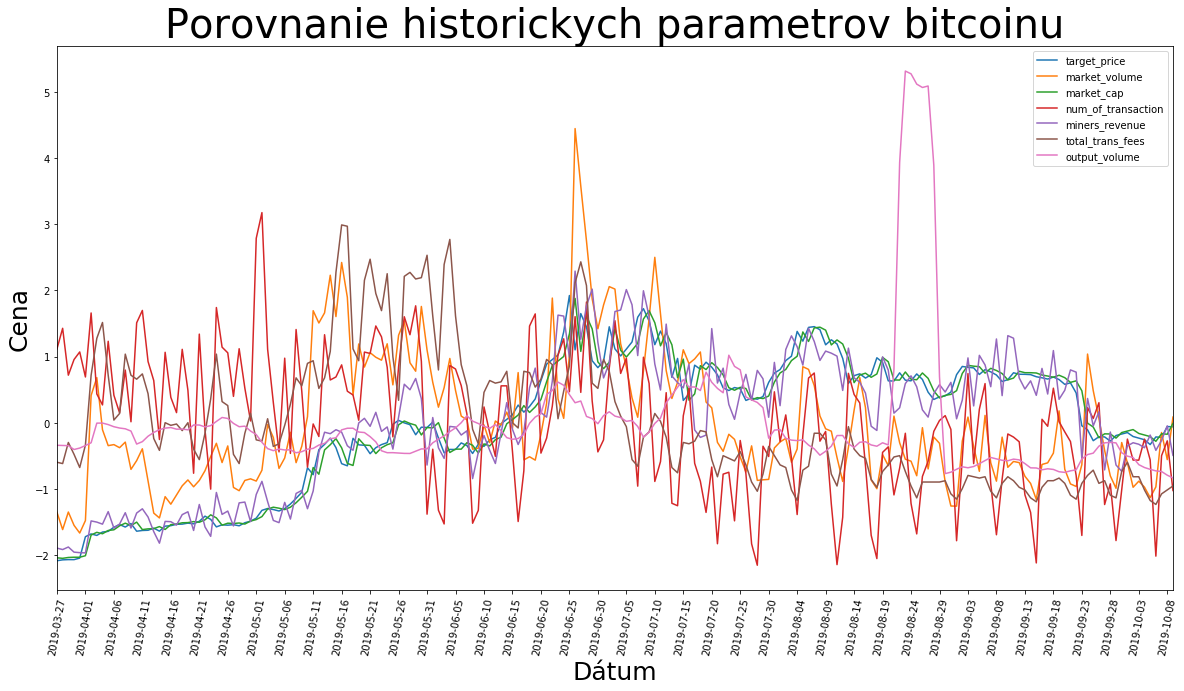

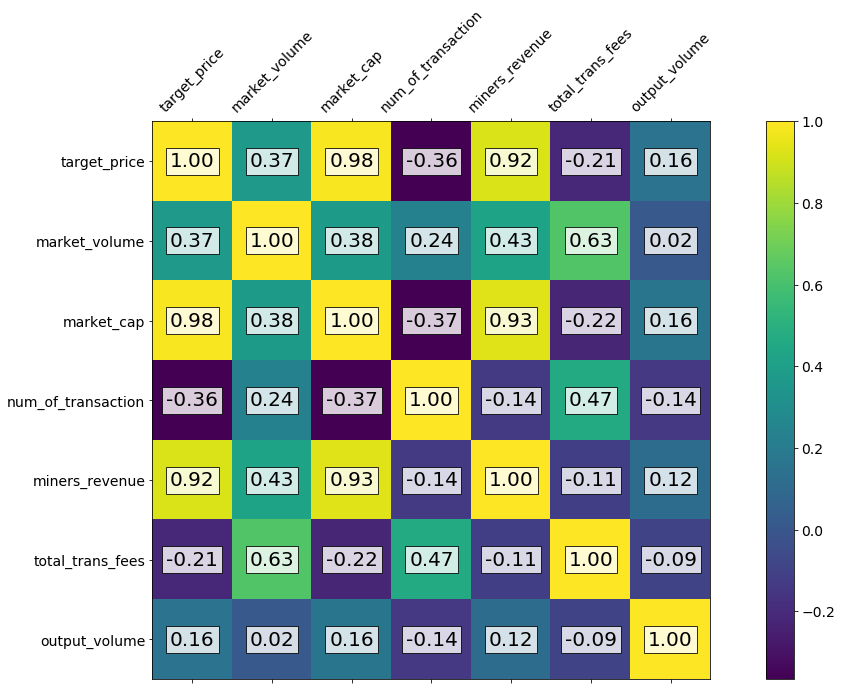

In [110]:
dfc = PlotColumn(dff, ['target_price','market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees','output_volume'], scaler = StandardScaler(), title ='Porovnanie historickych parametrov bitcoinu',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for target_price autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for market_volume autocorrelation:  " + str(AutocorrelationTest(dfc.market_volume)))
print("Durbin-Watson test for market_cap autocorrelation:  " + str(AutocorrelationTest(dfc.market_cap)))
print("Durbin-Watson test for num_of_transaction autocorrelation:  " + str(AutocorrelationTest(dfc.num_of_transaction)))
print("Durbin-Watson test for miners_revenue autocorrelation:  " + str(AutocorrelationTest(dfc.miners_revenue)))
print("Durbin-Watson test for total_trans_fees autocorrelation:  " + str(AutocorrelationTest(dfc.total_trans_fees)))
print("Durbin-Watson test for output_volume autocorrelation:  " + str(AutocorrelationTest(dfc.output_volume)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

In [111]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price','market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees','output_volume']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_market_volume'] = np.insert(np.diff(dff['market_volume']), 0, 0)
dff['d_market_cap'] = np.insert(np.diff(dff['market_cap']), 0, 0)
dff['d_num_of_transaction'] = np.insert(np.diff(dff['num_of_transaction']), 0, 0)
dff['d_miners_revenue'] = np.insert(np.diff(dff['miners_revenue']), 0, 0)
dff['d_total_trans_fees'] = np.insert(np.diff(dff['total_trans_fees']), 0, 0)
dff['d_output_volume'] = np.insert(np.diff(dff['output_volume']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  market_volume    market_cap  num_of_transaction  \
1  2019-03-27      4087.07   1.089713e+10  7.198785e+10              383186   
2  2019-03-28      4069.11   9.353916e+09  7.167900e+10              393698   
3  2019-03-29      4098.37   1.091867e+10  7.220209e+10              369817   
4  2019-03-30      4106.66   9.732688e+09  7.235519e+10              377783   
5  2019-03-31      4105.40   9.045122e+09  7.233938e+10              381652   

   miners_revenue  total_trans_fees  output_volume  target_price  \
1         7663796                48        1229363       4069.11   
2         7555049                47        1227019       4098.37   
3         7747502                63        1223853       4106.66   
4         7361068                54        1162220       4105.40   
5         7323231                44        1185152       4158.18   

   d_target_price  d_market_volume  d_market_cap  d_num_of_transaction  \
1          -17.96     1.894531e+08  1.803700e+09                 16771   
2           29.26    -1.543216e+09 -3.088487e+08                 10512   
3            8.29     1.564750e+09  5.230900e+08                -23881   
4           -1.26    -1.185977e+09  1.531018e+08                  7966   
5           52.78    -6.875656e+08 -1.581161e+07                  3869   

   d_miners_revenue  d_total_trans_fees  d_output_volume  
1            931169                  12           -32963  
2           -108747                  -1            -2344  
3            192453                  16            -3166  
4           -386434                  -9           -61633  
5            -37837                 -10            22932

Durbin-Watson test for d_target_price autocorrelation:  2.205179885558197
Durbin-Watson test for d_market_volume autocorrelation:  2.0687948141300656
Durbin-Watson test for d_market_cap autocorrelation:  2.199760538112392
Durbin-Watson test for d_num_of_transaction autocorrelation:  2.4402467926045306
Durbin-Watson test for d_miners_revenue autocorrelation:  2.7498451834640973
Durbin-Watson test for d_total_trans_fees autocorrelation:  1.7590720356162155
Durbin-Watson test for d_output_volume autocorrelation:  0.8502579712255358
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


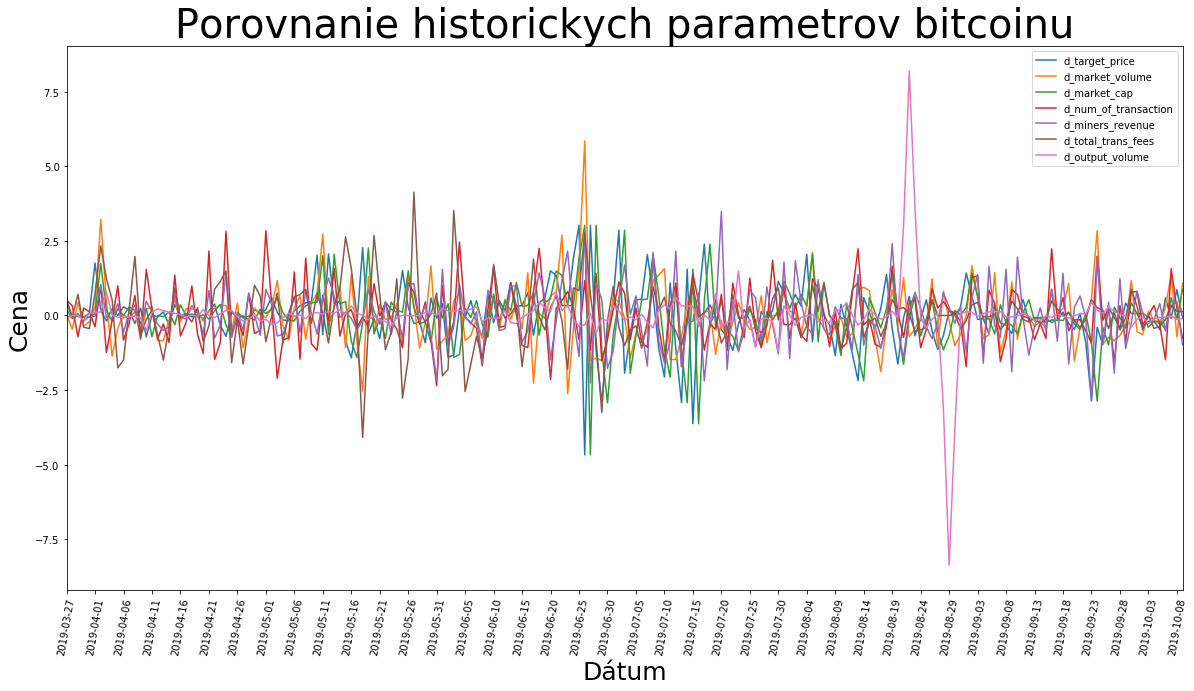

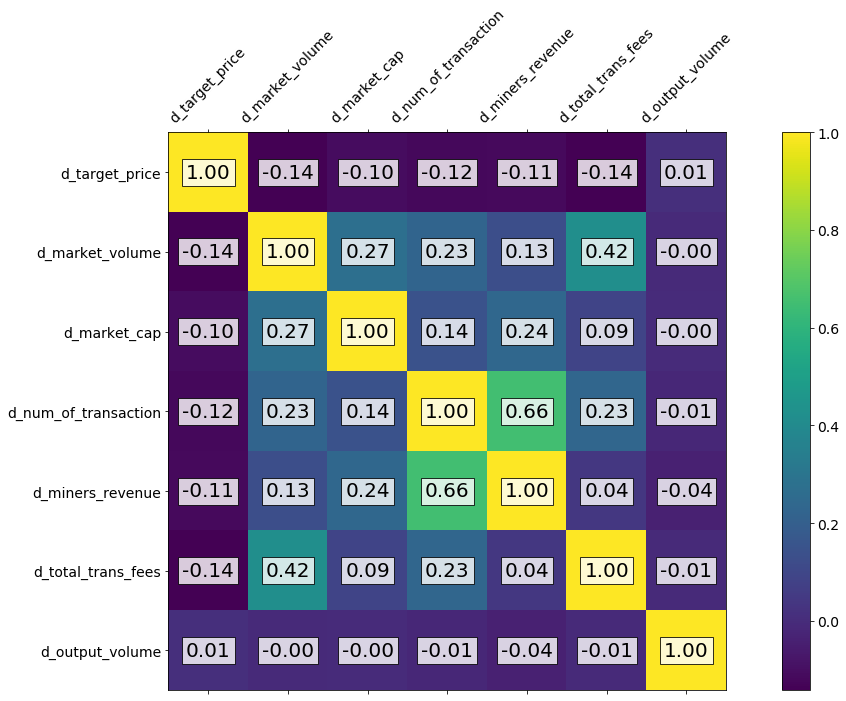

In [112]:
dfc = PlotColumn(dff, ['d_target_price','d_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees','d_output_volume'], scaler = StandardScaler(), title ='Porovnanie historickych parametrov bitcoinu',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc)
print("Durbin-Watson test for d_target_price autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for d_market_volume autocorrelation:  " + str(AutocorrelationTest(dfc.d_market_volume)))
print("Durbin-Watson test for d_market_cap autocorrelation:  " + str(AutocorrelationTest(dfc.d_market_cap)))
print("Durbin-Watson test for d_num_of_transaction autocorrelation:  " + str(AutocorrelationTest(dfc.d_num_of_transaction)))
print("Durbin-Watson test for d_miners_revenue autocorrelation:  " + str(AutocorrelationTest(dfc.d_miners_revenue)))
print("Durbin-Watson test for d_total_trans_fees autocorrelation:  " + str(AutocorrelationTest(dfc.d_total_trans_fees)))
print("Durbin-Watson test for d_output_volume autocorrelation:  " + str(AutocorrelationTest(dfc.d_output_volume)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

In [119]:
df = pd.read_csv("data.csv")
dff = df[['date', 'close_price','market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees','output_volume']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
dff['d_market_volume'] = np.insert(np.diff(dff['market_volume']), 0, 0)
dff['d_market_cap'] = np.insert(np.diff(dff['market_cap']), 0, 0)
dff['d_num_of_transaction'] = np.insert(np.diff(dff['num_of_transaction']), 0, 0)
dff['d_miners_revenue'] = np.insert(np.diff(dff['miners_revenue']), 0, 0)
dff['d_total_trans_fees'] = np.insert(np.diff(dff['total_trans_fees']), 0, 0)
dff['d_output_volume'] = np.insert(np.diff(dff['output_volume']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  market_volume    market_cap  num_of_transaction  \
1  2019-03-27      4087.07   1.089713e+10  7.198785e+10              383186   
2  2019-03-28      4069.11   9.353916e+09  7.167900e+10              393698   
3  2019-03-29      4098.37   1.091867e+10  7.220209e+10              369817   
4  2019-03-30      4106.66   9.732688e+09  7.235519e+10              377783   
5  2019-03-31      4105.40   9.045122e+09  7.233938e+10              381652   

   miners_revenue  total_trans_fees  output_volume  target_price  \
1         7663796                48        1229363       4069.11   
2         7555049                47        1227019       4098.37   
3         7747502                63        1223853       4106.66   
4         7361068                54        1162220       4105.40   
5         7323231                44        1185152       4158.18   

   d_target_price  d_market_volume  d_market_cap  d_num_of_transaction  \
1          -17.96     1.894531e+08  1.803700e+09                 16771   
2           29.26    -1.543216e+09 -3.088487e+08                 10512   
3            8.29     1.564750e+09  5.230900e+08                -23881   
4           -1.26    -1.185977e+09  1.531018e+08                  7966   
5           52.78    -6.875656e+08 -1.581161e+07                  3869   

   d_miners_revenue  d_total_trans_fees  d_output_volume  
1            931169                  12           -32963  
2           -108747                  -1            -2344  
3            192453                  16            -3166  
4           -386434                  -9           -61633  
5            -37837                 -10            22932

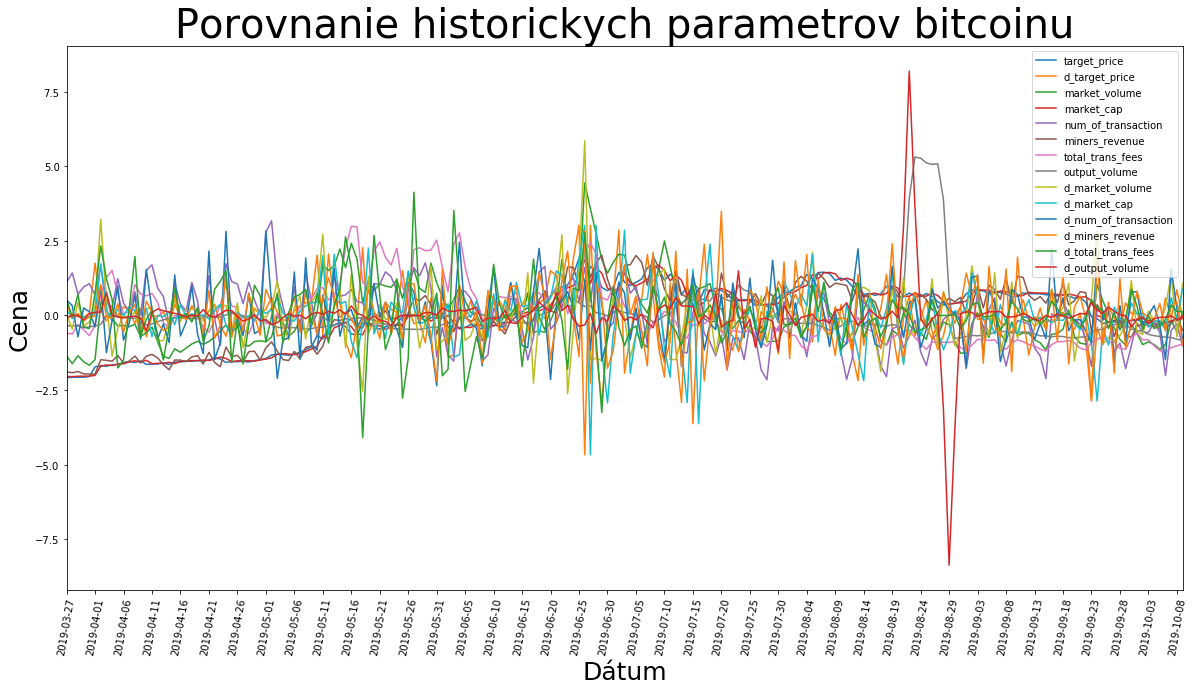

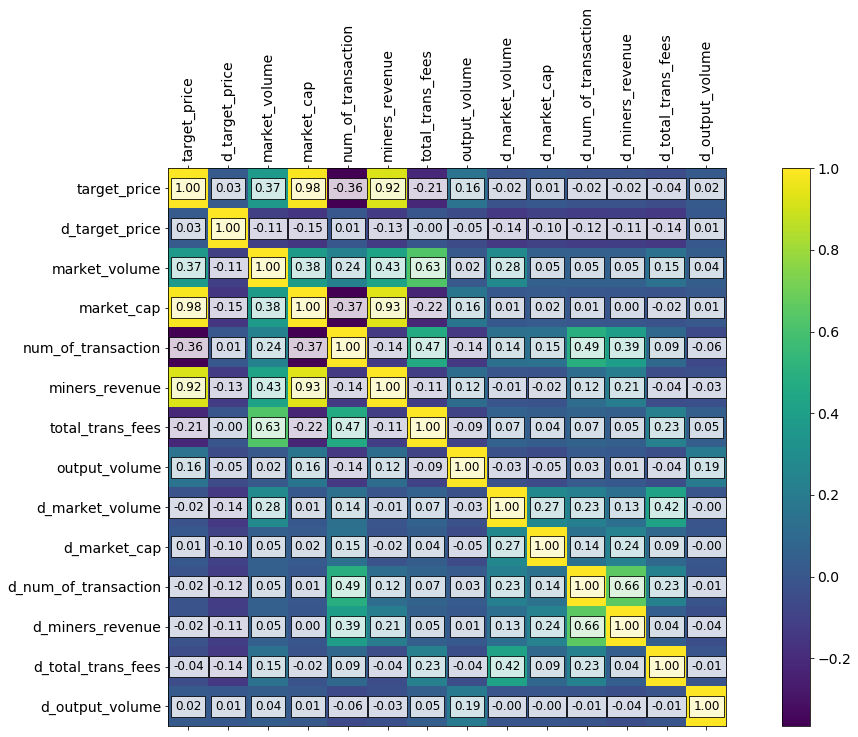

In [120]:
dfc = PlotColumn(dff, ['target_price','d_target_price', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees','output_volume','d_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees','d_output_volume'], scaler = StandardScaler(), title ='Porovnanie historickych parametrov bitcoinu',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 12)

# Classification SECTION

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC  
 - SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001,    cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)  
 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier  
 - RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
 - GaussianNB(priors=None, var_smoothing=1e-09)
 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier  
 - KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)


In [321]:
def PrepareDataset():
    df = pd.read_csv("data.csv")
    dff = df[['date', 'open_price', 'close_price','market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees','output_volume']].copy()
    dff['target_price'] = dff['close_price'].shift(-1) 
    dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
    dff['d_price_move'] = dff.close_price - dff.open_price
    dff['d_market_volume'] = np.insert(np.diff(dff['market_volume']), 0, 0)
    dff['d_market_cap'] = np.insert(np.diff(dff['market_cap']), 0, 0)
    dff['d_num_of_transaction'] = np.insert(np.diff(dff['num_of_transaction']), 0, 0)
    dff['d_miners_revenue'] = np.insert(np.diff(dff['miners_revenue']), 0, 0)
    dff['d_total_trans_fees'] = np.insert(np.diff(dff['total_trans_fees']), 0, 0)
    dff['d_output_volume'] = np.insert(np.diff(dff['output_volume']), 0, 0)
    dff = dff[:-1]
    dff = dff.iloc[1:]
    dff['target_rise_fall'] = (dff.d_target_price>0.0)
    return dff

def GetColumnSet(choice = None):
    if choice == 'basic':
        ret = ['target_rise_fall','d_price_move','market_volume','market_cap','num_of_transaction','miners_revenue','total_trans_fees','output_volume']
        msg = ret
    elif choice == 'difference':
        ret = ['target_rise_fall','d_price_move','d_market_volume','d_market_cap','d_num_of_transaction','d_miners_revenue','d_total_trans_fees','d_output_volume']
        msg = ret
    elif choice is None:
        ret = None
        msg = 'ALL'
    print("Selected columns>> " + str(msg)+"\n\n")
    return ret

# Random Forrest whole set

In [322]:
###CLASSIFICATION###DONT MOVE PrepareDataset()  TO SEPARATE BLOCK  - DF must be initialized every time

dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101), columns = GetColumnSet())
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ALL


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.60      0.62      0.61        24
        True       0.61      0.58      0.60        24

    accuracy                           0.60        48
   macro avg       0.60      0.60      0.60        48
weighted avg       0.60      0.60      0.60        48

----------------Confusion_matrix--------------
[[15  9]
 [10 14]]
--------------------Accuracy------------------
0.6041666666666666


importance
d_total_trans_fees    0.094513
total_trans_fees      0.088762
num_of_transaction    0.082061
close_price           0.075721
d_market_volume       0.074983
market_cap            0.073954
open_price            0.071744
miners_revenue        0.071703
output_volume         0.059626
market_volume         0.056074

# Random Forrest just base features

In [323]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
rf, X_train = Predict(dff, scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = GetColumnSet('basic'))
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ['target_rise_fall', 'd_price_move', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees', 'output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.62      0.67      0.64        24
        True       0.64      0.58      0.61        24

    accuracy                           0.62        48
   macro avg       0.63      0.62      0.62        48
weighted avg       0.63      0.62      0.62        48

----------------Confusion_matrix--------------
[[16  8]
 [10 14]]
--------------------Accuracy------------------
0.625


importance
num_of_transaction    0.167511
market_cap            0.149721
total_trans_fees      0.146771
market_volume         0.143108
output_volume         0.136499
miners_revenue        0.132607
d_price_move          0.123782

# Random Forrest just difference features

In [324]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
rf, X_train = Predict(dff, scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = GetColumnSet('difference'))
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ['target_rise_fall', 'd_price_move', 'd_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees', 'd_output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.57      0.33      0.42        24
        True       0.53      0.75      0.62        24

    accuracy                           0.54        48
   macro avg       0.55      0.54      0.52        48
weighted avg       0.55      0.54      0.52        48

----------------Confusion_matrix--------------
[[ 8 16]
 [ 6 18]]
--------------------Accuracy------------------
0.5416666666666666


importance
d_market_volume         0.182702
d_total_trans_fees      0.158025
d_market_cap            0.141337
d_miners_revenue        0.132036
d_output_volume         0.131903
d_num_of_transaction    0.128658
d_price_move            0.125338

# GaussianNB - whole dataset

In [325]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = GaussianNB())

(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.62      0.75      0.68        24
        True       0.68      0.54      0.60        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.64        48
weighted avg       0.65      0.65      0.64        48

----------------Confusion_matrix--------------
[[18  6]
 [11 13]]
--------------------Accuracy------------------
0.6458333333333334


# GaussianNB - base features

In [326]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = GaussianNB(), columns = GetColumnSet("basic"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees', 'output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.69      0.46      0.55        24
        True       0.59      0.79      0.68        24

    accuracy                           0.62        48
   macro avg       0.64      0.62      0.61        48
weighted avg       0.64      0.62      0.61        48

----------------Confusion_matrix--------------
[[11 13]
 [ 5 19]]
--------------------Accuracy------------------
0.625


# GaussianNB - difference features

In [327]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = GaussianNB(), columns = GetColumnSet("difference"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'd_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees', 'd_output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.53      0.33      0.41        24
        True       0.52      0.71      0.60        24

    accuracy                           0.52        48
   macro avg       0.52      0.52      0.50        48
weighted avg       0.52      0.52      0.50        48

----------------Confusion_matrix--------------
[[ 8 16]
 [ 7 17]]
--------------------Accuracy------------------
0.5208333333333334


# SVM - whole dataset

In [328]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet())

Selected columns>> ALL


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.70      0.58      0.64        24
        True       0.64      0.75      0.69        24

    accuracy                           0.67        48
   macro avg       0.67      0.67      0.66        48
weighted avg       0.67      0.67      0.66        48

----------------Confusion_matrix--------------
[[14 10]
 [ 6 18]]
--------------------Accuracy------------------
0.6666666666666666


# SVM - base features

In [329]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet("basic"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees', 'output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.75      0.50      0.60        24
        True       0.62      0.83      0.71        24

    accuracy                           0.67        48
   macro avg       0.69      0.67      0.66        48
weighted avg       0.69      0.67      0.66        48

----------------Confusion_matrix--------------
[[12 12]
 [ 4 20]]
--------------------Accuracy------------------
0.6666666666666666


# SVM - difference features

In [330]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet("difference"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'd_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees', 'd_output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.33      0.12      0.18        24
        True       0.46      0.75      0.57        24

    accuracy                           0.44        48
   macro avg       0.40      0.44      0.38        48
weighted avg       0.40      0.44      0.38        48

----------------Confusion_matrix--------------
[[ 3 21]
 [ 6 18]]
--------------------Accuracy------------------
0.4375



# KNeighborsClassifier - whole dataset

In [331]:
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet())

Selected columns>> ALL


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.72      0.54      0.62        24
        True       0.63      0.79      0.70        24

    accuracy                           0.67        48
   macro avg       0.68      0.67      0.66        48
weighted avg       0.68      0.67      0.66        48

----------------Confusion_matrix--------------
[[13 11]
 [ 5 19]]
--------------------Accuracy------------------
0.6666666666666666


# KNeighborsClassifier - base data

In [332]:
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet("basic"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'market_volume', 'market_cap', 'num_of_transaction', 'miners_revenue', 'total_trans_fees', 'output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.64      0.67      0.65        24
        True       0.65      0.62      0.64        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.65        48
weighted avg       0.65      0.65      0.65        48

----------------Confusion_matrix--------------
[[16  8]
 [ 9 15]]
--------------------Accuracy------------------
0.6458333333333334


# KNeighborsClassifier - difference data

In [333]:
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = MinMaxScaler(feature_range=(-1, 1), copy=True) , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet("difference"))

Selected columns>> ['target_rise_fall', 'd_price_move', 'd_market_volume', 'd_market_cap', 'd_num_of_transaction', 'd_miners_revenue', 'd_total_trans_fees', 'd_output_volume']


(197, 19)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.53      0.38      0.44        24
        True       0.52      0.67      0.58        24

    accuracy                           0.52        48
   macro avg       0.52      0.52      0.51        48
weighted avg       0.52      0.52      0.51        48

----------------Confusion_matrix--------------
[[ 9 15]
 [ 8 16]]
--------------------Accuracy------------------
0.5208333333333334
